## Generate simulation data

In [1]:
import joblib
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from numpy.ma.core import exp


In [2]:
# define some functions to generate the simulation data

def generate_S0(n0):
    S01=np.random.normal(size=n0)
    S02=np.random.beta(a=2,b=2,size=n0)
    return np.vstack((S01,S02)).T

def generate_Ut(n0):
    return np.random.normal(size=n0)
    #return (np.random.binomial(size=n0, n=1, p= 0.5)-0.5)*2

def generate_Zt(St,n0):
    dt=0.1*np.random.normal(size=n0)
    p=1/(1+exp(-(St[:,0]+St[:,1]+dt-1))).data
    return np.random.binomial(1,p,size=n0)

def generate_At(St,Zt,Ut,n0):
    p=1/(1+exp(-(St[:,0]+2*Zt*St[:,1]+0.1*Ut*(1-St[:,1])-1.5))).data
    #p=1/(1+exp(-(St[:,0]+2*Zt*St[:,1]+Ut*(1-St[:,1])-1.5))).data
    return np.random.binomial(1,p,size=n0)

def generate_Rt(St,At,Ut,n0):
    return (0.5*St[:,0]+0.5*At*St[:,1]+0.2*Ut*(1-St[:,1]))
    #return (0.5*St[:,0]+0.5*At*St[:,1]+Ut*(1-St[:,1]))

def generate_Stplus1(St,At,Ut,n0):
    Stplus11=0.8*St[:,0]+0.5*At+0.1*Ut
    Stplus12=1/(1+exp(-(St[:,1]+At+0.1*Ut-1))).data
    #Stplus11=0.8*St[:,0]+0.5*At+Ut
    #Stplus12=1/(1+exp(-(St[:,1]+At+Ut-1))).data
    return np.vstack((Stplus11,Stplus12)).T


In [3]:
# generate simulation dataset
# the number of samples
n=10**3
# the number of stages
T=120
p=2


np.random.seed(525)
S0=generate_S0(n)
MDP = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n)
    Zt=generate_Zt(St,n)
    At=generate_At(St,Zt,Ut,n)
    Rt=generate_Rt(St,At,Ut,n)
    Stplus1=generate_Stplus1(St,At,Ut,n)
    MDP = np.hstack((MDP, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
    St=Stplus1


MDP=MDP[:,(20*(p+3)):(120*(p+3)+p)]
print(np.shape(MDP))



(1000, 502)


In [4]:
pd.DataFrame(MDP)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,-0.360915,0.293458,0.0,0.0,-0.202176,-0.304102,0.326972,0.0,0.0,-0.039526,...,1.0,1.0,1.078473,1.764098,0.644155,1.0,1.0,1.248564,1.973718,0.669648
1,2.511137,0.650084,1.0,1.0,1.621994,2.568042,0.670228,1.0,1.0,1.517793,...,1.0,1.0,1.473610,2.313028,0.658699,1.0,1.0,1.451177,2.299608,0.647458
2,0.826832,0.608565,0.0,0.0,0.454041,0.713358,0.415921,1.0,1.0,0.635756,...,1.0,1.0,1.031850,1.614013,0.691743,1.0,0.0,0.783117,1.252461,0.414108
3,1.539982,0.628000,1.0,1.0,1.194353,1.880321,0.684890,1.0,1.0,1.370893,...,1.0,1.0,1.428679,2.289381,0.651748,1.0,1.0,1.482927,2.349254,0.661391
4,0.046284,0.338699,1.0,1.0,0.067686,0.442663,0.560782,0.0,1.0,0.465076,...,1.0,1.0,0.557765,1.170072,0.573584,1.0,1.0,0.856856,1.418501,0.635533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.092706,0.396045,0.0,0.0,0.130276,0.143643,0.369473,1.0,1.0,0.354466,...,1.0,1.0,0.474893,1.077885,0.564340,1.0,1.0,0.881486,1.431597,0.653312
996,2.178097,0.635471,1.0,1.0,1.537968,2.422414,0.693261,1.0,0.0,1.190310,...,1.0,1.0,1.745798,2.750929,0.664078,1.0,1.0,1.862193,2.930989,0.709782
997,2.177052,0.690103,1.0,1.0,1.345004,2.098734,0.633485,1.0,0.0,1.059101,...,1.0,1.0,1.674101,2.633631,0.701902,0.0,0.0,1.351930,2.165803,0.440483
998,0.806824,0.344937,0.0,1.0,0.681505,1.226081,0.604812,0.0,0.0,0.720605,...,0.0,0.0,0.943828,1.342357,0.393682,1.0,0.0,0.583488,1.001572,0.336567


In [5]:
p=2
Pi=1
gamma=0.9
domain_At=np.array([0,1])
domain_Zt=np.array([0,1])
max_iter=1000
epsilon=5e-4

## true value

In [6]:
# approximate the true value of eta_pi by MC method
# the first step is to generate a dataset that follows target policy Pi.
# in this case, we specify At=np.ones(n0)*Pi where Pi can be 0 or 1.

np.random.seed(525)
n0=10**5 # the number of trajectories in MC approximation. The larger the better.
T_burn=20
p=2
T=100 # the number of stages
p=2
gamma=0.9

S0=generate_S0(n0)
MDP_burn = np.copy(S0)
St=S0
for i in range(T_burn):
    Ut=generate_Ut(n0)
    Zt=generate_Zt(St,n0)
    At=generate_At(St,Zt,Ut,n0)
    Rt=generate_Rt(St,At,Ut,n0)
    Stplus1=generate_Stplus1(St,At,Ut,n0)
    MDP_burn = np.hstack((MDP_burn, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
    St=Stplus1

#print(np.shape(MDP_burn))


S0=MDP_burn[:,T_burn*(p+3):(T_burn*(p+3)+2)]

MDP0 = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n0)
    Zt=generate_Zt(St,n0)
    At=np.ones(n0)*Pi # generate Ai following Pi
    Rt=generate_Rt(St,At,Ut,n0)
    Stplus1=generate_Stplus1(St,At,Ut,n0)
    MDP0 = np.hstack((MDP0, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
    St=Stplus1
#MDP0=MDP0[:,(20*(p+3)):(120*(p+3)+p)]
print(np.shape(MDP0))

# true value of $\eta_{\pi}$ can be estimated by MC method:
eta_pi_true=0
for t in range(T):
    eta_pi_true=eta_pi_true+(gamma**(t))*sum(MDP0[:,(p+2)+(p+3)*t])/n0
    
eta_pi_true



(100000, 502)


13.864399680475394

## comparison

#### IVRL

In [ ]:
def IVRL_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3):

    # =============================================================================
    # IV+MDP. Off policy evaluation: estimate the averaged treatment effect in infinite-horizon MDP settings
    # -------------------------------------------------------------------------
    #  parameters:
    #  MDP: dataframe, which contains all observed data formalized 
    #       as (St,Zt,At,Rt) from stage 1 to T. St can be multi-dimensional.
    #  p: the dimension of state variable St
    #  n: the number of trajectories
    #  T: the number of stages
    #  Pi: the target policy we want to evaluate
    #  gamma: discount factor
    #  domain_At: the domain/support of action space
    #  domain_Zt: the domain/support of IV space
    #  max_iter: maximum number of iterations in fitted-Q evaluation
    #  epsilon: error bound in fitted-Q evaluation
    #  
    #  
    # =============================================================================


    # load packages
    import joblib
    import numpy as np
    import random
    import time
    import pandas as pd
    import matplotlib.pyplot as plt

    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import LinearRegression
    from numpy.linalg import inv
    from sklearn.kernel_approximation import RBFSampler

    # vectorize the data for further use
    if (p==1):
      index_S=np.linspace(0,T-1,T)*4
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
    else:
      index_S=np.linspace(0,T-1,T)*(p+3)
      for i in range(1,p):
        index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S].T.reshape(p,-1).T
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T

    index_Z=np.linspace(0,T-1,T)*(p+3)+p
    index_A=np.linspace(0,T-1,T)*(p+3)+p+1
    index_R=np.linspace(0,T-1,T)*(p+3)+p+2
    index_SZ=np.concatenate((index_S,index_Z))

    MDP_S=MDP[:,index_S.astype(int)]
    MDP_SZ=MDP[:,index_SZ.astype(int)]
    MDP_A=MDP[:,index_A.astype(int)]

    Zvec=MDP[:,index_Z.astype(int)].T.reshape(-1,1)
    SZvec=np.hstack((Svec,Zvec))
    Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
    Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

    nall=n*T

    # estimate models:
    ## (1) estimate Action model p_a(a|s,z) with the first 90% samples
    A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    A_model.fit(SZvec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
    # print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
    print("pa model performance (accuracy): ", A_model.score(SZvec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")
    def Pa(St,Zt,n,A_model):
      if ((n==1) and (p==1)):
        return A_model.predict_proba(np.array([St,Zt]).reshape(1, -1))[0]
      elif ((n==1) and (p!=1)):
        return A_model.predict_proba(np.concatenate((St,np.array([Zt]))).reshape(1, -1))[0]
      else:
        return A_model.predict_proba(np.hstack((St,Zt)))


    ## (2) estimate P11 := p_a(At=1|Zt=1,St)
    def P11(St,n,A_model):
      if (n==1):
        return Pa(St,1,n,A_model)[1]
      else:
        return Pa(St,np.ones(n).reshape(-1,1),n,A_model)[:,1]

    ## (3) estimate P10 := p_a(At=1|Zt=0,St)
    def P10(St,n,A_model):
      if (n==1):
        return Pa(St,0,n,A_model)[1]
      else:
        return Pa(St,np.zeros(n).reshape(-1,1),n,A_model)[:,1]

    ## (4) estimate c(Zt|St)
    def c(Zt,St,n,Pi,A_model):
      if (n==1):
        c=Zt*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
        return c
      else:
        c=Zt.T*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt.T)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
        return c[0]

    ## (5) estimate pz(Zt|St)
    Z_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    Z_model.fit(Svec[range(int(n*T*0.9))], Zvec[range(int(n*T*0.9))].reshape(1,-1)[0])
    print("pz model performance (accuracy): ", Z_model.score(Svec[range(int(n*T*0.9),n*T)], Zvec[range(int(n*T*0.9),n*T)], sample_weight=None),"\n")

    def Pz(Zt,St,n,Z_model):
      if ((n==1) and (p==1)):
        return Z_model.predict_proba(np.array([St]).reshape(1, -1))[0][int(Zt)]
      elif ((n==1) and (p!=1)):
        return Z_model.predict_proba(St.reshape(1, -1))[0][int(Zt)]
      else:
        return Z_model.predict_proba(St)[:,1]*Zt.T[0] + Z_model.predict_proba(St)[:,0]*(1-Zt.T[0])

    ## (6) estimate $\rho(Z_t,S_t)$
    def rho(St,Zt,n,Pi,A_model):
      return c(Zt,St,n,Pi,A_model)/Pz(Zt,St,n,Z_model)

    print("Start estimating omega_pi(St):")
    ## (7) estimate $\omega^{\pi}(s)$: should change if St continuous, and here we only specify linear function class for xi
    class RatioLinearLearner:
        '''
        Input
        --------
        cplearner is an object of rho or PALearner. 
        It gives estimators for conditional probability of behaviour policy: 
        P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
        Examples
        --------
        '''
        def __init__(self, dataset, policy, time_difference=None, gamma=0.9, ndim=100, l2penalty=0.01, use_IV=True, rho=rho, A_model=A_model, truncate=20):
            self.use_IV = use_IV

            self.state = np.copy(dataset['state'])
            self.action = np.copy(dataset['action']).reshape(-1, 1)
            self.unique_action = np.unique(dataset['action'])
            if use_IV:
                self.IV = np.copy(dataset['IV']).reshape(-1, 1)
            self.next_state = np.copy(dataset['next_state'])
            self.s0 = np.copy(dataset['s0'])
            if time_difference is None:
                self.time_difference = np.ones(self.action.shape[0])
            else:
                self.time_difference = np.copy(time_difference)

            self.policy = policy

            self.gamma = gamma
            self.l2penalty = l2penalty
            self.beta = None
            self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
            self.rbf_feature.fit(np.vstack((self.state, self.s0)))
            self.truncate = truncate
            pass

        def feature_engineering(self, feature):
            feature_new = self.rbf_feature.transform(feature)
            feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
            return feature_new

        def target_policy_pa(self, target_policy, state, action):
            num = action.shape[0]
            target_pa = list(range(num))
            for i in range(num):
                target_pa[i] = target_policy(state[i], action[i])
                pass
            target_pa = np.array(target_pa).flatten()
            return target_pa

        def fit(self):
            psi = self.feature_engineering(self.state)
            psi_next = self.feature_engineering(self.next_state)
            if self.use_IV:
                ratio = rho(self.state,self.IV,len(self.action),Pi,A_model)
            #else:
                  #estimate_pa = self.PALearner.get_pa_prediction(self.state, self.action)
                  #target_pa = self.target_policy_pa(self.policy, self.state, self.action)
                  #pa_ratio = target_pa / estimate_pa
                  #ratio = pa_ratio

            # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
            psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
            design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
            for i in range(self.state.shape[0]):
                design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
            # design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
            design_matrix /= self.state.shape[0]
            # print(design_matrix)
            penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # if psi.shape[0] <= psi.shape[1]:
            #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # else:
            #     penalty_matrix = np.zeros(design_matrix.shape)
            penalize_design_matrix = design_matrix + penalty_matrix
            inv_design_matrix = inv(penalize_design_matrix)

            # psi_s0 = self.feature_engineering(self.s0)
            # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            # print(mean_psi_s0)
            mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

            beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
            self.beta = beta
            pass
        
        def rbf_difference(self, psi, psi_next, ratio):
            # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
            psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                                  np.power(self.gamma, self.time_difference)[:, np.newaxis])
            psi_minus_psi_next = psi - psi_next
            return psi_minus_psi_next

        def get_ratio_prediction(self, state, normalize=True):
            '''
            Input:
            state: a numpy.array
            Output:
            A 1D numpy array. The probability ratio in certain states.
            '''
            if np.ndim(state) == 0 or np.ndim(state) == 1:
                x_state = np.reshape(state, (1, -1))
            else:
                x_state = np.copy(state)
            psi = self.feature_engineering(x_state)
            ratio = np.matmul(psi, self.beta).flatten()
            ratio_min = 1 / self.truncate
            ratio_max = self.truncate
            ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
            if state.shape[0] > 1:
                if normalize:
                    ratio /= np.mean(ratio)
            return ratio
        
        def ratio_expectation_s0(self, s0):
            psi_s0 = self.feature_engineering(s0)
            mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            return mean_psi_s0

        def get_r_prediction(self, state, normalize=True):
            return self.get_ratio_prediction(state, normalize)

    def Pi_func(state,action):
        return Pi

    state_all=Svec
    IV=Zvec.T[0]
    action=Avec.T[0]
    reward=Rvec.T[0]
    next_state_all=Splus1_vec

    iid_dataset = [state_all, action, IV, reward, next_state_all]

    s0=MDP[:,0:p]
    dataset = {'s0': s0, 'state': state_all, 
            'action': action, 'IV': IV,
            'reward': reward, 
            "next_state": next_state_all}

    
    rlearner = RatioLinearLearner(dataset, Pi_func, ndim = 50, use_IV= True, rho=rho, A_model=A_model)
    rlearner.fit()
    omega_all=rlearner.get_ratio_prediction(state_all)

    print("omega_pi(St) estimation finished.\n")


    print("Start estimating Q function and Value function (fitted Q evaluation):")
    ## (8) estimate Q function: we only specify Q as a linear function of (St,Zt,At). Can be generalized later.
    # Q function: a linear function of (St,Zt,At). Can be modified later.
    def Q(beta,n,St,Zt,At):
      if ((n==1) and (p==1)):
        #return np.dot(np.array([St,Zt,At]),beta)
        return np.dot(np.array([1,St,Zt,At]),beta)
      elif ((n==1) and (p!=1)):
        #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
        return np.dot(np.concatenate((np.array([1]),St,np.array([Zt]),np.array([At]))),beta)
      else:
        #return np.dot(np.hstack((St,Zt,At)),beta)
        return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,Zt,At)),beta)################################3

    ## (9) estimate Value function based on Q function estimation result 
    def V(St, n, Pi, beta, domain_Zt, domain_At, A_model):
      len_Zt=len(domain_Zt)
      len_At=len(domain_At)
      if (n==1):
        V_St=0
        for i in range(len_Zt):
          for j in range(len_At):
            V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q(beta,n,St,domain_Zt[i],domain_At[j])
            #V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_model.predict(np.concatenate((St,np.array([domain_Zt[i]]),np.array([domain_At[j]]))))
      else:
        V_St=np.zeros(n)
        for i in range(len_Zt):
          for j in range(len_At):
            V_St=V_St+c(domain_Zt[i]*np.ones(n).reshape(-1,1),St,n,Pi,A_model)*Pa(St,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]*Q(beta,n,St,domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1))
            #V_St=V_St+c(np.ones(n)*domain_Zt[i].reshape(-1,1),St,n,Pi,A_model)*Pa(St,np.ones(n)*domain_Zt[i].reshape(-1,1),n,A_model)[:,j]*Q_model.predict(np.hstack((St,np.ones(n)*domain_Zt[i].reshape(-1,1),np.ones(n)*domain_At[j].reshape(-1,1))))

      return V_St

    # estimate the parameters beta in both Q function and Value function
    nfeatures=p+2
    nall=n*T

    part1_Q=0
    part2_Q=0
    for t in range(T):
      xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p+2)]),axis=1)

      f_tplus1_Q=np.zeros((n,nfeatures+1))
      Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
      for i in range(len_Zt):
        for j in range(len_At):
          xi_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)],domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1)),axis=1)
          coef_Q=c(domain_Zt[i]*np.ones(n).reshape(-1,1),Stplus1,n,Pi,A_model)*Pa(Stplus1,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]
          f_tplus1_Q=f_tplus1_Q+xi_tplus1_Q* coef_Q[:, np.newaxis]

      part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
      R_t_Q=MDP[:,((p+3)*t+p+2)]
      part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

    beta_Q=np.linalg.solve(part1_Q,part2_Q)

    print("Estimated beta_Q is: ", beta_Q)
    print("Q function and Value function estimation finished.\n")


    # calculate the augmentation terms by function phi_aug
    def phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q):
      
      phi_result=0
      #phi_result_part1=0
      #phi_result_part2=0

      for t in range(T):
        if (p==1):
          Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n, A_model=A_model)
          phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
          phi_2=np.zeros(n)
          for i in range(n):
            for a in domain_At:
              phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=MDP[i,4*t+1],At=a)

          phi_3=MDP[:,4*t+2]-Pa_At[:,1]
          phi_3_2=np.zeros(n)
          delta_a=(Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
          for i in range(n):
            for z in domain_Zt:
              for a in domain_At:
                phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=z,At=a)
          
          phi_3=phi_3*phi_3_2
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
          rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
        else:
          Pa_At=Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n, A_model=A_model)
          phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
          phi_2=np.zeros(n)
          for i in range(n):
            for a in domain_At:
              phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=MDP[i,(p+3)*t+p],At=a)

          phi_3=MDP[:,(p+3)*t+p+1]-Pa_At[:,1]
          phi_3_2=np.zeros(n)
          delta_a=(Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
          for i in range(n):
            for z in domain_Zt:
              for a in domain_At:
                phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,At=a)
          
          phi_3=phi_3*phi_3_2
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
          rho_StZt=rho(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
        
        
        phi_result=phi_result+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2+phi_3))

        #phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2))
        #phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*phi_3)

      phi_result=phi_result/n/(T)
      #phi_result_part1=phi_result_part1/n/(T)
      #phi_result_part2=phi_result_part2/n/(T)

      #return np.array([phi_result,phi_result_part1,phi_result_part2])
      return phi_result


    print("Start calculating DM estimator:")
    # calculate the direct estimator
    eta_pi_DM=0
    for i in range(n):
      for z in range(2):
        for a in range(2):
          eta_pi_DM=eta_pi_DM+c(Zt=z,St=MDP[i,0:p],n=1,Pi=Pi,A_model=A_model)*Pa(Zt=z,St=MDP[i,0:p],n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,0:p],Zt=z,At=a)
    eta_pi_DM=eta_pi_DM/n
    print("DM estimator: eta_pi_DM=", eta_pi_DM)
    print("DM estimator calculation finished.\n")

    print("Start calculating augmentation terms:")
    # calculate the augmentation terms by function phi_aug
    eta_pi_aug=phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q)
    print("Augmentation term: eta_pi_aug=", eta_pi_aug)
    print("Augmentation terms calculation finished.\n")

    # the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
    eta_pi_DR=eta_pi_DM+eta_pi_aug
    
    return eta_pi_DR




#### Other methods: NUC

In [ ]:
def DRL_NUC_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3):

    # =============================================================================
    # Double reinforcement learning with NO unmeasured confounders. 
    # -------------------------------------------------------------------------
    #  parameters:
    #  MDP: dataframe, which contains all observed data formalized 
    #       as (St,Zt,At,Rt) from stage 1 to T. St can be multi-dimensional.
    #  p: the dimension of state variable St
    #  n: the number of trajectories
    #  T: the number of stages
    #  Pi: the target policy we want to evaluate
    #  gamma: discount factor
    #  domain_At: the domain/support of action space
    #  domain_Zt: the domain/support of IV space
    #  max_iter: maximum number of iterations in fitted-Q evaluation
    #  epsilon: error bound in fitted-Q evaluation
    #  
    #  
    # =============================================================================


    # load packages
    import joblib
    import numpy as np
    import random
    import time
    import pandas as pd
    import matplotlib.pyplot as plt

    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import LinearRegression

    # vectorize the data for further use
    if (p==1):
      index_S=np.linspace(0,T-1,T)*4
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
    else:
      index_S=np.linspace(0,T-1,T)*(p+3)
      for i in range(1,p):
        index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S].T.reshape(p,-1).T
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T


    index_A=np.linspace(0,T-1,T)*(p+3)+p+1
    index_R=np.linspace(0,T-1,T)*(p+3)+p+2

    MDP_S=MDP[:,index_S.astype(int)]
    MDP_A=MDP[:,index_A.astype(int)]

    Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
    Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

    nall=n*T

    # estimate models:
    ## (1) estimate Action model p_a(a|s) with the first 90% samples
    A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    A_model.fit(Svec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
    # print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
    print("pa model performance (accuracy): ", A_model.score(Svec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")


    def Pa(St,n,p,A_model):
      if ((n==1) and (p==1)):
        return A_model.predict_proba(np.array([St]).reshape(1, -1))[0]
      elif ((n==1) and (p!=1)):
        return A_model.predict_proba(St.reshape(1, -1))[0]
      else:
        return A_model.predict_proba(St)

    #from scipy.interpolate import BSpline

    ## (9) estimate Q function: we only specify Q as a linear function of (St,At). Can be generalized later.
    # Q function: a linear function of (St,At). Can be modified later.
    def Q(beta,n,St,At):
      if ((n==1) and (p==1)):
        #return np.dot(np.array([St,Zt,At]),beta)
        return np.dot(np.array([1,St,At]),beta)
      elif ((n==1) and (p!=1)):
        #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
        return np.dot(np.concatenate((np.array([1]),St,np.array([At]))),beta)
      else:
        #return np.dot(np.hstack((St,Zt,At)),beta)
        return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,At)),beta)################################3

    ## (10) estimate Value function based on Q function estimation result 
    def V(St, n, Pi, beta):
      # deterministic policy Pi: here we just test Pi=1. The whole function can be generalized to random policy later.
      if (n==1):
        V_St=Q(beta,n,St,Pi)
      else:
        V_St=Q(beta,n,St,Pi*np.ones(n).reshape(-1,1))

      return V_St


    # estimate the parameters beta in both Q function and Value function
    nfeatures=p+1
    nall=n*T

    part1_Q=0
    part2_Q=0
    for t in range(T):
      xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,((p+3)*t+p+1)].reshape(-1,1)),axis=1)

      Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
      f_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),Stplus1,Pi*np.ones(n).reshape(-1,1)),axis=1)


      part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
      R_t_Q=MDP[:,((p+3)*t+p+2)]
      part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

    beta_Q_NUC=np.linalg.solve(part1_Q,part2_Q)

    # DM estimator:
    eta_pi_est_DM_NUC=0
    for i in range(n):
      eta_pi_est_DM_NUC=eta_pi_est_DM_NUC+V(MDP[i,0:p],1,Pi,beta_Q_NUC) # corre
    eta_pi_est_DM_NUC=eta_pi_est_DM_NUC/n

    print("DM estimator under NUC: ",eta_pi_est_DM_NUC) 


    ## (7) estimate beta_pi
    def beta_pi(St,At,p,n,Pi,A_model):
      if (n==1):
        return Pi*At/(Pa(St,1,2,A_model)[int(At)])
      else:
        return (At.T[0])*Pi/(At.T[0]*Pa(St,n,2,A_model)[:,1]+(1-At.T[0])*Pa(St,n,2,A_model)[:,0])


    ## (8) estimate $\omega^{\pi}(s)$: here we only specify linear function class for xi
    # -*- coding: utf-8 -*-

    import numpy as np
    from numpy.linalg import inv
    from sklearn.kernel_approximation import RBFSampler

    class RatioLinearLearner_NUC:
        '''
        Input
        --------
        cplearner is an object of rho or PALearner. 
        It gives estimators for conditional probability of behaviour policy: 
        P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
        Examples
        --------
        '''
        def __init__(self, dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100, l2penalty=0.01, use_IV=False, truncate=20):
            self.use_IV=use_IV
            self.state = np.copy(dataset['state'])
            self.action = np.copy(dataset['action']).reshape(-1, 1)
            self.unique_action = np.unique(dataset['action'])

            self.next_state = np.copy(dataset['next_state'])
            self.s0 = np.copy(dataset['s0'])
            if time_difference is None:
                self.time_difference = np.ones(self.action.shape[0])
            else:
                self.time_difference = np.copy(time_difference)
            self.beta_pi=beta_pi
            self.policy = policy
            self.A_model = A_model

            self.gamma = gamma
            self.l2penalty = l2penalty
            self.beta = None
            self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
            self.rbf_feature.fit(np.vstack((self.state, self.s0)))
            self.truncate = truncate
            pass

        def feature_engineering(self, feature):
            feature_new = self.rbf_feature.transform(feature)
            feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
            return feature_new

        def target_policy_pa(self, target_policy, state, action):
            num = action.shape[0]
            target_pa = list(range(num))
            for i in range(num):
                target_pa[i] = target_policy(state[i], action[i])
                pass
            target_pa = np.array(target_pa).flatten()
            return target_pa

        def fit(self):
            psi = self.feature_engineering(self.state)
            psi_next = self.feature_engineering(self.next_state)
            if self.use_IV:
                rho(self.state,self.IV.reshape(-1,1),len(self.action),Pi,A_model)
            else:
                ratio = beta_pi(self.state, self.action,p,n,Pi,self.A_model)

            # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
            psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
            design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
            for i in range(self.state.shape[0]):
                design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
            # design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
            design_matrix /= self.state.shape[0]
            # print(design_matrix)
            penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # if psi.shape[0] <= psi.shape[1]:
            #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # else:
            #     penalty_matrix = np.zeros(design_matrix.shape)
            penalize_design_matrix = design_matrix + penalty_matrix
            inv_design_matrix = inv(penalize_design_matrix)

            # psi_s0 = self.feature_engineering(self.s0)
            # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            # print(mean_psi_s0)
            mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

            beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
            self.beta = beta
            pass
        
        def rbf_difference(self, psi, psi_next, ratio):
            # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
            psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                                  np.power(self.gamma, self.time_difference)[:, np.newaxis])
            psi_minus_psi_next = psi - psi_next
            return psi_minus_psi_next

        def get_ratio_prediction(self, state, normalize=True):
            '''
            Input:
            state: a numpy.array
            Output:
            A 1D numpy array. The probability ratio in certain states.
            '''
            if np.ndim(state) == 0 or np.ndim(state) == 1:
                x_state = np.reshape(state, (1, -1))
            else:
                x_state = np.copy(state)
            psi = self.feature_engineering(x_state)
            ratio = np.matmul(psi, self.beta).flatten()
            ratio_min = 1 / self.truncate
            ratio_max = self.truncate
            ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
            if state.shape[0] > 1:
                if normalize:
                    ratio /= np.mean(ratio)
            return ratio
        
        def ratio_expectation_s0(self, s0):
            psi_s0 = self.feature_engineering(s0)
            mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            return mean_psi_s0

        def get_r_prediction(self, state, normalize=True):
            return self.get_ratio_prediction(state, normalize)



    def Pi_func(state,action):
        return Pi

    state_all=Svec
    action=Avec.T[0]
    reward=Rvec.T[0]
    next_state_all=Splus1_vec

    iid_dataset = [state_all, action, reward, next_state_all]

    s0=MDP[:,0:p]
    dataset = {'s0': s0, 'state': state_all, 
            'action': action,
            'reward': reward, 
            "next_state": next_state_all}

    #dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100,
    rlearner_NUC = RatioLinearLearner_NUC(dataset, Pi_func, beta_pi, ndim = 50, use_IV= False, A_model=A_model)
    rlearner_NUC.fit()
    omega_all_NUC=rlearner_NUC.get_ratio_prediction(state_all)



    '''
    # MIS estimator:
    eta_pi_est_MIS_NUC=0

    for t in range(T):
      eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)*beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,((p+3)*t+p+1)].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)* MDP[:,((p+3)*t+p+2)]

    eta_pi_est_MIS_NUC=sum(eta_pi_est_MIS_NUC)/n/(T)/(1-gamma)

    print("MIS estimator under NUC: ",eta_pi_est_MIS_NUC) 
    '''

    # calculate the augmentation terms in our DR estimator by function phi_aug
    def phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC):
      
      phi_result=0
      eta_pi_est_MIS_NUC=0

      for t in range(T):
        if (p==1):
          phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q_NUC)
          phi_2=Q(beta_Q_NUC,n,MDP[:,4*t].reshape(-1,1),MDP[:,4*t+2].reshape(-1,1))
          #omega_St=omega(MDP[:,4*t].reshape(-1,1),n,p,beta_omega_NUC)
          beta_St=beta_pi(St=MDP[:,4*t].reshape(-1,1),At=MDP[:,4*t+2].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)

        else:
          phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q_NUC)
          phi_2=Q(beta_Q_NUC,n,MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,(p+3)*t+p+1].reshape(-1,1))
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)
          beta_St=beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,(p+3)*t+p+1].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)

        phi_result=phi_result+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(phi_1-phi_2))
        eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(MDP[:,(p+3)*t+p+2]))

      phi_result=phi_result/n/(T)
      eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC/n/(T)

      return phi_result, eta_pi_est_MIS_NUC


    eta_pi_est_aug_NUC, eta_pi_est_MIS_NUC=phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC)  

    print("MIS estimator under NUC: ",eta_pi_est_MIS_NUC) 
    # the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
    eta_pi_est_DR_NUC=eta_pi_est_DM_NUC+eta_pi_est_aug_NUC
    print("DRL estimator under NUC: ",eta_pi_est_DR_NUC) 

    return eta_pi_est_MIS_NUC, eta_pi_est_DM_NUC, eta_pi_est_DR_NUC




#### Run

In [ ]:
REP=10
est_IVMDP=np.zeros((200,10))
est_DM=np.zeros((200,10))
est_MIS=np.zeros((200,10))
est_DRL=np.zeros((200,10))

np.random.seed(528)

n_all=np.array([100,200,300,400,500,600,700,800,900,1000])

for rep in range(REP):
  print("rep=",rep,":\n")
  for j in range(10):
  
    # generate MDP
    n=n_all[j]

    # the number of stages
    T=120
    p=2

    S0=generate_S0(n)
    MDP = np.copy(S0)
    St=S0
    for i in range(T):
        Ut=generate_Ut(n)
        Zt=generate_Zt(St,n)
        At=generate_At(St,Zt,Ut,n)
        Rt=generate_Rt(St,At,Ut,n)
        Stplus1=generate_Stplus1(St,At,Ut,n)
        MDP = np.hstack((MDP, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
        St=Stplus1


    MDP=MDP[:,(20*(p+3)):(120*(p+3)+p)]
    T=100

    est_IVMDP[rep,j]=IVRL_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3)
    est_MIS[rep,j],est_DM[rep,j],est_DRL[rep,j]=DRL_NUC_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3)






rep= 0 :

pa model performance (accuracy):  0.769 

pz model performance (accuracy):  0.812 

Start estimating omega_pi(St):
omega_pi(St) estimation finished.

Start estimating Q function and Value function (fitted Q evaluation):
Estimated beta_Q is:  [ 9.64867835e+00  1.77372000e+00  4.74776031e-01 -7.98774161e-03
  1.21190432e+00]
Q function and Value function estimation finished.

Start calculating DM estimator:
DM estimator: eta_pi_DM= 13.595398373314675
DM estimator calculation finished.

Start calculating augmentation terms:
Augmentation term: eta_pi_aug= -5.469841589390267
Augmentation terms calculation finished.

pa model performance (accuracy):  0.756 

DM estimator under NUC:  13.694752404522823
MIS estimator under NUC:  11.16993867931761
DRL estimator under NUC:  13.639385263785845
pa model performance (accuracy):  0.767 

pz model performance (accuracy):  0.7995 

Start estimating omega_pi(St):
omega_pi(St) estimation finished.

Start estimating Q function and Value functio

In [ ]:
est_IVMDP[range(2),:]

array([[ 11.2388282 ,  24.98911364,   9.9954041 ,  11.23895326,
         11.0355834 ,  11.22909884,  11.29168453,  11.38139939,
         13.28554557,  11.2572625 ],
       [ 10.39440934,  11.08618531,  11.4426939 ,   6.96982552,
         10.54937847, -12.00307626,  11.28155228,  11.35757051,
         11.24142223,  11.19782606]])

In [ ]:
est_IVMDP=est_IVMDP[range(2),:]
est_DM=est_DM[range(2),:]
est_MIS=est_MIS[range(2),:]
est_DRL=est_DRL[range(2),:]



In [ ]:
MSE_IVMDP=np.sum((est_IVMDP-eta_pi_true)**2,0)/2
MSE_DM=np.sum((est_DM-eta_pi_true)**2,0)/2
MSE_MIS=np.sum((est_MIS-eta_pi_true)**2,0)/2
MSE_DRL=np.sum((est_DRL-eta_pi_true)**2,0)/2

Bias_IVMDP=np.sum((est_IVMDP-eta_pi_true),0)/2
Bias_DM=np.sum((est_DM-eta_pi_true),0)/2
Bias_MIS=np.sum((est_MIS-eta_pi_true),0)/2
Bias_DRL=np.sum((est_DRL-eta_pi_true),0)/2

In [ ]:
MSE_IVMDP=np.sum((est_IVMDP[:,range(6,10)]-eta_pi_true)**2,0)/2
MSE_DM=np.sum((est_DM[:,range(6,10)]-eta_pi_true)**2,0)/2
MSE_MIS=np.sum((est_MIS[:,range(6,10)]-eta_pi_true)**2,0)/2
MSE_DRL=np.sum((est_DRL[:,range(6,10)]-eta_pi_true)**2,0)/2

Bias_IVMDP=np.sum((est_IVMDP[:,range(6,10)]-eta_pi_true),0)/2
Bias_DM=np.sum((est_DM[:,range(6,10)]-eta_pi_true),0)/2
Bias_MIS=np.sum((est_MIS[:,range(6,10)]-eta_pi_true),0)/2
Bias_DRL=np.sum((est_DRL[:,range(6,10)]-eta_pi_true),0)/2

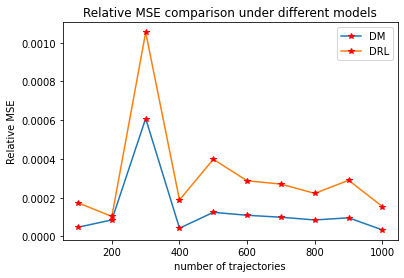

In [ ]:
import matplotlib.pylab as pyl
 
trajectory = [100,200,300,400,500,600,700,800,900,1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)


#pyl.xlim(0, 20)
#pyl.ylim(0.25, 2)
 

#ax1.plot(trajectory, MSE_IVMDP/eta_pi_true**2,marker='*', mec='r', mfc='r', label='IVMDP')
ax1.plot(trajectory, MSE_DM/eta_pi_true**2,marker='*', mec='r', mfc='r', label='DM')
ax1.plot(trajectory, MSE_DRL/eta_pi_true**2,marker='*', mec='r', mfc='r', label='DRL')
plt.legend(loc='upper right')

plt.title("Relative MSE comparison under different models")
plt.xlabel("number of trajectories")
plt.ylabel("Relative MSE")
plt.show()

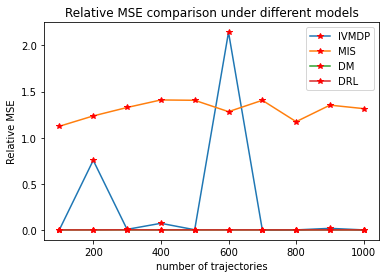

In [ ]:
import matplotlib.pylab as pyl
 
trajectory = [100,200,300,400,500,600,700,800,900,1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)


#pyl.xlim(0, 20)
#pyl.ylim(0.25, 2)
 

ax1.plot(trajectory, MSE_IVMDP/eta_pi_true**2,marker='*', mec='r', mfc='r', label='IVMDP')
ax1.plot(trajectory, MSE_MIS/eta_pi_true**2,marker='*', mec='r', mfc='r', label='MIS')
ax1.plot(trajectory, MSE_DM/eta_pi_true**2,marker='*', mec='r', mfc='r', label='DM')
ax1.plot(trajectory, MSE_DRL/eta_pi_true**2,marker='*', mec='r', mfc='r', label='DRL')

plt.legend(loc='upper right')

plt.title("Relative MSE comparison under different models")
plt.xlabel("number of trajectories")
plt.ylabel("Relative MSE")
plt.show()

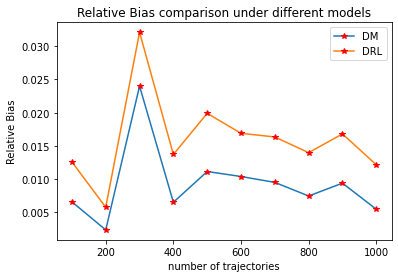

In [ ]:
import matplotlib.pylab as pyl
 
trajectory = [100,200,300,400,500,600,700,800,900,1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)


#pyl.xlim(0, 20)
#pyl.ylim(0.25, 2)
 

#ax1.plot(trajectory, abs(Bias_IVMDP/eta_pi_true),marker='*', mec='r', mfc='r', label='IVMDP')
ax1.plot(trajectory, abs(Bias_DM/eta_pi_true),marker='*', mec='r', mfc='r', label='DM')
ax1.plot(trajectory, abs(Bias_DRL/eta_pi_true),marker='*', mec='r', mfc='r', label='DRL')
plt.legend(loc='upper right')

plt.title("Relative Bias comparison under different models")
plt.xlabel("number of trajectories")
plt.ylabel("Relative Bias")
plt.show()

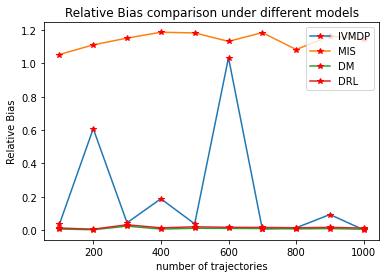

In [ ]:
import matplotlib.pylab as pyl
 
trajectory = [100,200,300,400,500,600,700,800,900,1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)


#pyl.xlim(0, 20)
#pyl.ylim(0.25, 2)
 

ax1.plot(trajectory, abs(Bias_IVMDP/eta_pi_true),marker='*', mec='r', mfc='r', label='IVMDP')
ax1.plot(trajectory, abs(Bias_MIS/eta_pi_true),marker='*', mec='r', mfc='r', label='MIS')
ax1.plot(trajectory, abs(Bias_DM/eta_pi_true),marker='*', mec='r', mfc='r', label='DM')
ax1.plot(trajectory, abs(Bias_DRL/eta_pi_true),marker='*', mec='r', mfc='r', label='DRL')
plt.legend(loc='upper right')

plt.title("Relative Bias comparison under different models")
plt.xlabel("number of trajectories")
plt.ylabel("Relative Bias")
plt.show()

## IVRL

In [ ]:
def IVRL_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3):

    # =============================================================================
    # IV+MDP. Off policy evaluation: estimate the averaged treatment effect in infinite-horizon MDP settings
    # -------------------------------------------------------------------------
    #  parameters:
    #  MDP: dataframe, which contains all observed data formalized 
    #       as (St,Zt,At,Rt) from stage 1 to T. St can be multi-dimensional.
    #  p: the dimension of state variable St
    #  n: the number of trajectories
    #  T: the number of stages
    #  Pi: the target policy we want to evaluate
    #  gamma: discount factor
    #  domain_At: the domain/support of action space
    #  domain_Zt: the domain/support of IV space
    #  max_iter: maximum number of iterations in fitted-Q evaluation
    #  epsilon: error bound in fitted-Q evaluation
    #  
    #  
    # =============================================================================


    # load packages
    import joblib
    import numpy as np
    import random
    import time
    import pandas as pd
    import matplotlib.pyplot as plt

    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import LinearRegression
    from numpy.linalg import inv
    from sklearn.kernel_approximation import RBFSampler

    # vectorize the data for further use
    if (p==1):
      index_S=np.linspace(0,T-1,T)*4
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
    else:
      index_S=np.linspace(0,T-1,T)*(p+3)
      for i in range(1,p):
        index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S].T.reshape(p,-1).T
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T

    index_Z=np.linspace(0,T-1,T)*(p+3)+p
    index_A=np.linspace(0,T-1,T)*(p+3)+p+1
    index_R=np.linspace(0,T-1,T)*(p+3)+p+2
    index_SZ=np.concatenate((index_S,index_Z))

    MDP_S=MDP[:,index_S.astype(int)]
    MDP_SZ=MDP[:,index_SZ.astype(int)]
    MDP_A=MDP[:,index_A.astype(int)]

    Zvec=MDP[:,index_Z.astype(int)].T.reshape(-1,1)
    SZvec=np.hstack((Svec,Zvec))
    Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
    Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

    nall=n*T

    # estimate models:
    ## (1) estimate Action model p_a(a|s,z) with the first 90% samples
    A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    A_model.fit(SZvec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
    # print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
    print("pa model performance (accuracy): ", A_model.score(SZvec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")
    def Pa(St,Zt,n,A_model):
      if ((n==1) and (p==1)):
        return A_model.predict_proba(np.array([St,Zt]).reshape(1, -1))[0]
      elif ((n==1) and (p!=1)):
        return A_model.predict_proba(np.concatenate((St,np.array([Zt]))).reshape(1, -1))[0]
      else:
        return A_model.predict_proba(np.hstack((St,Zt)))


    ## (2) estimate P11 := p_a(At=1|Zt=1,St)
    def P11(St,n,A_model):
      if (n==1):
        return Pa(St,1,n,A_model)[1]
      else:
        return Pa(St,np.ones(n).reshape(-1,1),n,A_model)[:,1]

    ## (3) estimate P10 := p_a(At=1|Zt=0,St)
    def P10(St,n,A_model):
      if (n==1):
        return Pa(St,0,n,A_model)[1]
      else:
        return Pa(St,np.zeros(n).reshape(-1,1),n,A_model)[:,1]

    ## (4) estimate c(Zt|St)
    def c(Zt,St,n,Pi,A_model):
      if (n==1):
        c=Zt*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
        return c
      else:
        c=Zt.T*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt.T)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
        return c[0]

    ## (5) estimate pz(Zt|St)
    Z_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    Z_model.fit(Svec[range(int(n*T*0.9))], Zvec[range(int(n*T*0.9))].reshape(1,-1)[0])
    print("pz model performance (accuracy): ", Z_model.score(Svec[range(int(n*T*0.9),n*T)], Zvec[range(int(n*T*0.9),n*T)], sample_weight=None),"\n")

    def Pz(Zt,St,n,Z_model):
      if ((n==1) and (p==1)):
        return Z_model.predict_proba(np.array([St]).reshape(1, -1))[0][int(Zt)]
      elif ((n==1) and (p!=1)):
        return Z_model.predict_proba(St.reshape(1, -1))[0][int(Zt)]
      else:
        return Z_model.predict_proba(St)[:,1]*Zt.T[0] + Z_model.predict_proba(St)[:,0]*(1-Zt.T[0])

    ## (6) estimate $\rho(Z_t,S_t)$
    def rho(St,Zt,n,Pi,A_model):
      return c(Zt,St,n,Pi,A_model)/Pz(Zt,St,n,Z_model)

    print("Start estimating omega_pi(St):")
    ## (7) estimate $\omega^{\pi}(s)$: should change if St continuous, and here we only specify linear function class for xi
    class RatioLinearLearner:
        '''
        Input
        --------
        cplearner is an object of rho or PALearner. 
        It gives estimators for conditional probability of behaviour policy: 
        P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
        Examples
        --------
        '''
        def __init__(self, dataset, policy, time_difference=None, gamma=0.9, ndim=100, l2penalty=1.0, use_IV=True, rho=rho, A_model=A_model, truncate=20):
            self.use_IV = use_IV

            self.state = np.copy(dataset['state'])
            self.action = np.copy(dataset['action']).reshape(-1, 1)
            self.unique_action = np.unique(dataset['action'])
            if use_IV:
                self.IV = np.copy(dataset['IV']).reshape(-1, 1)
            self.next_state = np.copy(dataset['next_state'])
            self.s0 = np.copy(dataset['s0'])
            if time_difference is None:
                self.time_difference = np.ones(self.action.shape[0])
            else:
                self.time_difference = np.copy(time_difference)

            self.policy = policy

            self.gamma = gamma
            self.l2penalty = l2penalty
            self.beta = None
            self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
            self.rbf_feature.fit(np.vstack((self.state, self.s0)))
            self.truncate = truncate
            pass

        def feature_engineering(self, feature):
            feature_new = self.rbf_feature.transform(feature)
            feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
            return feature_new

        def target_policy_pa(self, target_policy, state, action):
            num = action.shape[0]
            target_pa = list(range(num))
            for i in range(num):
                target_pa[i] = target_policy(state[i], action[i])
                pass
            target_pa = np.array(target_pa).flatten()
            return target_pa

        def fit(self):
            psi = self.feature_engineering(self.state)
            psi_next = self.feature_engineering(self.next_state)
            if self.use_IV:
                ratio = rho(self.state,self.IV,len(self.action),Pi,A_model)
            #else:
                  #estimate_pa = self.PALearner.get_pa_prediction(self.state, self.action)
                  #target_pa = self.target_policy_pa(self.policy, self.state, self.action)
                  #pa_ratio = target_pa / estimate_pa
                  #ratio = pa_ratio

            # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
            psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
            design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
            for i in range(self.state.shape[0]):
                design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
            # design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
            design_matrix /= self.state.shape[0]
            # print(design_matrix)
            penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # if psi.shape[0] <= psi.shape[1]:
            #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # else:
            #     penalty_matrix = np.zeros(design_matrix.shape)
            penalize_design_matrix = design_matrix + penalty_matrix
            inv_design_matrix = inv(penalize_design_matrix)

            # psi_s0 = self.feature_engineering(self.s0)
            # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            # print(mean_psi_s0)
            mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

            beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
            self.beta = beta
            pass
        
        def rbf_difference(self, psi, psi_next, ratio):
            # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
            psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                                  np.power(self.gamma, self.time_difference)[:, np.newaxis])
            psi_minus_psi_next = psi - psi_next
            return psi_minus_psi_next

        def get_ratio_prediction(self, state, normalize=True):
            '''
            Input:
            state: a numpy.array
            Output:
            A 1D numpy array. The probability ratio in certain states.
            '''
            if np.ndim(state) == 0 or np.ndim(state) == 1:
                x_state = np.reshape(state, (1, -1))
            else:
                x_state = np.copy(state)
            psi = self.feature_engineering(x_state)
            ratio = np.matmul(psi, self.beta).flatten()
            ratio_min = 1 / self.truncate
            ratio_max = self.truncate
            ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
            if state.shape[0] > 1:
                if normalize:
                    ratio /= np.mean(ratio)
            return ratio
        
        def ratio_expectation_s0(self, s0):
            psi_s0 = self.feature_engineering(s0)
            mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            return mean_psi_s0

        def get_r_prediction(self, state, normalize=True):
            return self.get_ratio_prediction(state, normalize)

    def Pi_func(state,action):
        return Pi

    state_all=Svec
    IV=Zvec.T[0]
    action=Avec.T[0]
    reward=Rvec.T[0]
    next_state_all=Splus1_vec

    iid_dataset = [state_all, action, IV, reward, next_state_all]

    s0=MDP[:,0:p]
    dataset = {'s0': s0, 'state': state_all, 
            'action': action, 'IV': IV,
            'reward': reward, 
            "next_state": next_state_all}

    
    rlearner = RatioLinearLearner(dataset, Pi_func, ndim = 50, use_IV= True, rho=rho, A_model=A_model)
    rlearner.fit()
    omega_all=rlearner.get_ratio_prediction(state_all)

    print("omega_pi(St) estimation finished.\n")


    print("Start estimating Q function and Value function (fitted Q evaluation):")
    ## (8) estimate Q function: we only specify Q as a linear function of (St,Zt,At). Can be generalized later.
    # Q function: a linear function of (St,Zt,At). Can be modified later.
    def Q(beta,n,St,Zt,At):
      if ((n==1) and (p==1)):
        #return np.dot(np.array([St,Zt,At]),beta)
        return np.dot(np.array([1,St,Zt,At]),beta)
      elif ((n==1) and (p!=1)):
        #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
        return np.dot(np.concatenate((np.array([1]),St,np.array([Zt]),np.array([At]))),beta)
      else:
        #return np.dot(np.hstack((St,Zt,At)),beta)
        return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,Zt,At)),beta)################################3

    ## (9) estimate Value function based on Q function estimation result 
    def V(St, n, Pi, beta, domain_Zt, domain_At, A_model):
      len_Zt=len(domain_Zt)
      len_At=len(domain_At)
      if (n==1):
        V_St=0
        for i in range(len_Zt):
          for j in range(len_At):
            V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q(beta,n,St,domain_Zt[i],domain_At[j])
            #V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_model.predict(np.concatenate((St,np.array([domain_Zt[i]]),np.array([domain_At[j]]))))
      else:
        V_St=np.zeros(n)
        for i in range(len_Zt):
          for j in range(len_At):
            V_St=V_St+c(domain_Zt[i]*np.ones(n).reshape(-1,1),St,n,Pi,A_model)*Pa(St,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]*Q(beta,n,St,domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1))
            #V_St=V_St+c(np.ones(n)*domain_Zt[i].reshape(-1,1),St,n,Pi,A_model)*Pa(St,np.ones(n)*domain_Zt[i].reshape(-1,1),n,A_model)[:,j]*Q_model.predict(np.hstack((St,np.ones(n)*domain_Zt[i].reshape(-1,1),np.ones(n)*domain_At[j].reshape(-1,1))))

      return V_St

    # estimate the parameters beta in both Q function and Value function
    nfeatures=p+2
    nall=n*T

    part1_Q=0
    part2_Q=0
    for t in range(T):
      xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p+2)]),axis=1)

      f_tplus1_Q=np.zeros((n,nfeatures+1))
      Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
      for i in range(len_Zt):
        for j in range(len_At):
          xi_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)],domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1)),axis=1)
          coef_Q=c(domain_Zt[i]*np.ones(n).reshape(-1,1),Stplus1,n,Pi,A_model)*Pa(Stplus1,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]
          f_tplus1_Q=f_tplus1_Q+xi_tplus1_Q* coef_Q[:, np.newaxis]

      part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
      R_t_Q=MDP[:,((p+3)*t+p+2)]
      part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

    beta_Q=np.linalg.solve(part1_Q,part2_Q)

    print("Estimated beta_Q is: ", beta_Q)
    print("Q function and Value function estimation finished.\n")


    # calculate the augmentation terms by function phi_aug
    def phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q):
      
      phi_result=0
      #phi_result_part1=0
      #phi_result_part2=0

      for t in range(T):
        if (p==1):
          Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n, A_model=A_model)
          phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
          phi_2=np.zeros(n)
          for i in range(n):
            for a in domain_At:
              phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=MDP[i,4*t+1],At=a)

          phi_3=MDP[:,4*t+2]-Pa_At[:,1]
          phi_3_2=np.zeros(n)
          delta_a=(Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
          for i in range(n):
            for z in domain_Zt:
              for a in domain_At:
                phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=z,At=a)
          
          phi_3=phi_3*phi_3_2
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
          rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
        else:
          Pa_At=Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n, A_model=A_model)
          phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
          phi_2=np.zeros(n)
          for i in range(n):
            for a in domain_At:
              phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=MDP[i,(p+3)*t+p],At=a)

          phi_3=MDP[:,(p+3)*t+p+1]-Pa_At[:,1]
          phi_3_2=np.zeros(n)
          delta_a=(Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
          for i in range(n):
            for z in domain_Zt:
              for a in domain_At:
                phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,At=a)
          
          phi_3=phi_3*phi_3_2
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
          rho_StZt=rho(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
        
        
        phi_result=phi_result+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2+phi_3))

        #phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2))
        #phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*phi_3)

      phi_result=phi_result/n/(T)
      #phi_result_part1=phi_result_part1/n/(T)
      #phi_result_part2=phi_result_part2/n/(T)

      #return np.array([phi_result,phi_result_part1,phi_result_part2])
      return phi_result


    print("Start calculating DM estimator:")
    # calculate the direct estimator
    eta_pi_DM=0
    for i in range(n):
      for z in range(2):
        for a in range(2):
          eta_pi_DM=eta_pi_DM+c(Zt=z,St=MDP[i,0:p],n=1,Pi=Pi,A_model=A_model)*Pa(Zt=z,St=MDP[i,0:p],n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,0:p],Zt=z,At=a)
    eta_pi_DM=eta_pi_DM/n
    print("DM estimator: eta_pi_DM=", eta_pi_DM)
    print("DM estimator calculation finished.\n")

    print("Start calculating augmentation terms:")
    # calculate the augmentation terms by function phi_aug
    eta_pi_aug=phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q)
    print("Augmentation term: eta_pi_aug=", eta_pi_aug)
    print("Augmentation terms calculation finished.\n")

    # the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
    eta_pi_DR=eta_pi_DM+eta_pi_aug
    
    return eta_pi_DR




In [ ]:
# it takes around 5 minutes to run the algorithm for a dataset with (n=1000, T=100)
eta_pi_est=IVRL_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3)

pa model performance (accuracy):  0.7813 

pz model performance (accuracy):  0.7956 

Start estimating omega_pi(St):
omega_pi(St) estimation finished.

Start estimating Q function and Value function (fitted Q evaluation):
Estimated beta_Q is:  [ 9.77314938e+00  1.78428898e+00  4.02169537e-01 -3.41005906e-03
  1.17657681e+00]
Q function and Value function estimation finished.

Start calculating DM estimator:
DM estimator: eta_pi_DM= 13.716723111156618
DM estimator calculation finished.

Start calculating augmentation terms:
Augmentation term: eta_pi_aug= -0.3118183587771255
Augmentation terms calculation finished.



In [ ]:
eta_pi_est # esta_pi estimated by our DR procedure

13.404904752379492

In [ ]:
print("The true value for eta_pi is: ", eta_pi_true, "; The estimated value for eta_pi is: ", eta_pi_est)
# the results are pretty close! YEAH!

The true value for eta_pi is:  13.864399680475394 ; The estimated value for eta_pi is:  13.404904752379492


### A splited version of the function "IVRL_TE_est"
The rest of this notbook is nothing but illustrating that each of the fragment of function "IVRL_TE_est" works well.

In [ ]:
import joblib
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor


In [ ]:
Pi=1   # just an example. 

In [ ]:
# generate simulation dataset
# the number of samples
n=10**3
# the number of stages
T=120
p=2


np.random.seed(525)
S0=generate_S0(n)
MDP = np.copy(S0)
St=S0
for i in range(T):
    Ut=generate_Ut(n)
    Zt=generate_Zt(St,n)
    At=generate_At(St,Zt,Ut,n)
    Rt=generate_Rt(St,At,Ut,n)
    Stplus1=generate_Stplus1(St,At,Ut,n)
    MDP = np.hstack((MDP, Zt.reshape(-1,1), At.reshape(-1,1), Rt.reshape(-1,1), Stplus1))
    St=Stplus1


MDP=MDP[:,(20*(p+3)):(120*(p+3)+p)]
print(np.shape(MDP))

T=100

(1000, 502)


In [ ]:
pd.DataFrame(MDP)

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,500,501
0,-0.360915,0.293458,0.0,0.0,-0.202176,-0.304102,0.326972,0.0,0.0,-0.039526,...,1.0,1.0,1.078473,1.764098,0.644155,1.0,1.0,1.248564,1.973718,0.669648
1,2.511137,0.650084,1.0,1.0,1.621994,2.568042,0.670228,1.0,1.0,1.517793,...,1.0,1.0,1.473610,2.313028,0.658699,1.0,1.0,1.451177,2.299608,0.647458
2,0.826832,0.608565,0.0,0.0,0.454041,0.713358,0.415921,1.0,1.0,0.635756,...,1.0,1.0,1.031850,1.614013,0.691743,1.0,0.0,0.783117,1.252461,0.414108
3,1.539982,0.628000,1.0,1.0,1.194353,1.880321,0.684890,1.0,1.0,1.370893,...,1.0,1.0,1.428679,2.289381,0.651748,1.0,1.0,1.482927,2.349254,0.661391
4,0.046284,0.338699,1.0,1.0,0.067686,0.442663,0.560782,0.0,1.0,0.465076,...,1.0,1.0,0.557765,1.170072,0.573584,1.0,1.0,0.856856,1.418501,0.635533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.092706,0.396045,0.0,0.0,0.130276,0.143643,0.369473,1.0,1.0,0.354466,...,1.0,1.0,0.474893,1.077885,0.564340,1.0,1.0,0.881486,1.431597,0.653312
996,2.178097,0.635471,1.0,1.0,1.537968,2.422414,0.693261,1.0,0.0,1.190310,...,1.0,1.0,1.745798,2.750929,0.664078,1.0,1.0,1.862193,2.930989,0.709782
997,2.177052,0.690103,1.0,1.0,1.345004,2.098734,0.633485,1.0,0.0,1.059101,...,1.0,1.0,1.674101,2.633631,0.701902,0.0,0.0,1.351930,2.165803,0.440483
998,0.806824,0.344937,0.0,1.0,0.681505,1.226081,0.604812,0.0,0.0,0.720605,...,0.0,0.0,0.943828,1.342357,0.393682,1.0,0.0,0.583488,1.001572,0.336567


In [ ]:

# load packages
import joblib
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression


# vectorize the data for further use
if (p==1):
  index_S=np.linspace(0,T-1,T)*4
  index_Splus1=index_S+(p+3)
  Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
  Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
else:
  index_S=np.linspace(0,T-1,T)*(p+3)
  for i in range(1,p):
    index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
  index_Splus1=index_S+(p+3)
  Svec=MDP[:,index_S].T.reshape(p,-1).T
  Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T

index_Z=np.linspace(0,T-1,T)*(p+3)+p
index_A=np.linspace(0,T-1,T)*(p+3)+p+1
index_R=np.linspace(0,T-1,T)*(p+3)+p+2
index_SZ=np.concatenate((index_S,index_Z))

MDP_S=MDP[:,index_S.astype(int)]
MDP_SZ=MDP[:,index_SZ.astype(int)]
MDP_A=MDP[:,index_A.astype(int)]

Zvec=MDP[:,index_Z.astype(int)].T.reshape(-1,1)
SZvec=np.hstack((Svec,Zvec))
Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)


In [ ]:
MDP[0:5,5:7]

array([[-0.30410161,  0.32697236],
       [ 2.56804246,  0.67022809],
       [ 0.71335841,  0.41592085],
       [ 1.88032121,  0.68488971],
       [ 0.44266345,  0.56078189]])

In [ ]:
Svec[1000:1005,:]

array([[-0.30410161,  0.32697236],
       [ 2.56804246,  0.67022809],
       [ 0.71335841,  0.41592085],
       [ 1.88032121,  0.68488971],
       [ 0.44266345,  0.56078189]])

In [ ]:
nall=n*T

In [ ]:
np.shape(SZvec) # nall*(p+1) dimensional

(100000, 3)

In [ ]:
# estimate models:

## (1) estimate Action model p_a(a|s,z) with the first 90% samples
A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
A_model.fit(SZvec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
# print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
print(A_model.score(SZvec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None))
def Pa(St,Zt,n,A_model):
  if ((n==1) and (p==1)):
    return A_model.predict_proba(np.array([St,Zt]).reshape(1, -1))[0]
  elif ((n==1) and (p!=1)):
    return A_model.predict_proba(np.concatenate((St,np.array([Zt]))).reshape(1, -1))[0]
  else:
    return A_model.predict_proba(np.hstack((St,Zt)))


0.7813


In [ ]:


## (2) estimate P11 := p_a(At=1|Zt=1,St)
def P11(St,n,A_model):
  if (n==1):
    return Pa(St,1,n,A_model)[1]
  else:
    return Pa(St,np.ones(n).reshape(-1,1),n,A_model)[:,1]

## (3) estimate P10 := p_a(At=1|Zt=0,St)
def P10(St,n,A_model):
  if (n==1):
    return Pa(St,0,n,A_model)[1]
  else:
    return Pa(St,np.zeros(n).reshape(-1,1),n,A_model)[:,1]

## (4) estimate c(Zt|St)
def c(Zt,St,n,Pi,A_model):
  if (n==1):
    c=Zt*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
    return c
  else:
    c=Zt.T*((Pi-P10(St,n,A_model))/(P11(St,n,A_model)-P10(St,n,A_model)))+(1-Zt.T)*((P11(St,n,A_model)-Pi)/(P11(St,n,A_model)-P10(St,n,A_model)))
    return c[0]
#from scipy.interpolate import BSpline




In [ ]:
print(Pa(St=np.array([[1,0.5],[0,0.5]]),Zt=np.ones(2).reshape(-1,1),n=2,A_model=A_model))
#print(Pa(St=np.array([1,0.5]),Zt=0,n=1,A_model=A_model))
#print(Pa(St=np.array([0,0.5]),Zt=1,n=1,A_model=A_model))
#print(Pa(St=np.array([0,0.5]),Zt=0,n=1,A_model=A_model))


[[0.36475976 0.63524024]
 [0.47797843 0.52202157]]


In [ ]:
print(c(Zt=np.array([1,1]).reshape(-1,1),St=np.array([[1,0.5],[0,0.5]]),n=2,Pi=Pi,A_model=A_model))
print(c(Zt=np.array([0,0]).reshape(-1,1),St=np.array([[1,0.5],[0,0.5]]),n=2,Pi=Pi,A_model=A_model))

[2.86094642 3.37980092]
[-1.86094642 -2.37980092]


In [ ]:
## (9) estimate Q function: we only specify Q as a linear function of (St,Zt,At). Can be generalized later.
# Q function: a linear function of (St,Zt,At). Can be modified later.
def Q(beta,n,St,Zt,At):
  if ((n==1) and (p==1)):
    #return np.dot(np.array([St,Zt,At]),beta)
    return np.dot(np.array([1,St,Zt,At]),beta)
  elif ((n==1) and (p!=1)):
    #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
    return np.dot(np.concatenate((np.array([1]),St,np.array([Zt]),np.array([At]))),beta)
  else:
    #return np.dot(np.hstack((St,Zt,At)),beta)
    return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,Zt,At)),beta)################################3

## (10) estimate Value function based on Q function estimation result 
def V(St, n, Pi, beta, domain_Zt, domain_At, A_model):
  len_Zt=len(domain_Zt)
  len_At=len(domain_At)
  if (n==1):
    V_St=0
    for i in range(len_Zt):
      for j in range(len_At):
        V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q(beta,n,St,domain_Zt[i],domain_At[j])
        #V_St=V_St+c(domain_Zt[i],St,n,Pi,A_model)*Pa(St,domain_Zt[i],n,A_model)[j]*Q_model.predict(np.concatenate((St,np.array([domain_Zt[i]]),np.array([domain_At[j]]))))
  else:
    V_St=np.zeros(n)
    for i in range(len_Zt):
      for j in range(len_At):
        V_St=V_St+c(domain_Zt[i]*np.ones(n).reshape(-1,1),St,n,Pi,A_model)*Pa(St,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]*Q(beta,n,St,domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1))
        #V_St=V_St+c(np.ones(n)*domain_Zt[i].reshape(-1,1),St,n,Pi,A_model)*Pa(St,np.ones(n)*domain_Zt[i].reshape(-1,1),n,A_model)[:,j]*Q_model.predict(np.hstack((St,np.ones(n)*domain_Zt[i].reshape(-1,1),np.ones(n)*domain_At[j].reshape(-1,1))))

  return V_St


In [ ]:

len_Zt=len(domain_Zt)
len_At=len(domain_At)
nfeatures=p+2
nall=n*T

part1_Q=0
part2_Q=0
for t in range(T):
  xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p+2)]),axis=1)

  f_tplus1_Q=np.zeros((n,nfeatures+1))
  Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
  for i in range(len_Zt):
    for j in range(len_At):
      xi_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)],domain_Zt[i]*np.ones(n).reshape(-1,1),domain_At[j]*np.ones(n).reshape(-1,1)),axis=1)
      coef_Q=c(domain_Zt[i]*np.ones(n).reshape(-1,1),Stplus1,n,Pi,A_model)*Pa(Stplus1,domain_Zt[i]*np.ones(n).reshape(-1,1),n,A_model)[:,j]
      f_tplus1_Q=f_tplus1_Q+xi_tplus1_Q* coef_Q[:, np.newaxis]

  part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
  R_t_Q=MDP[:,((p+3)*t+p+2)]
  part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

beta_Q=np.linalg.solve(part1_Q,part2_Q)


In [ ]:
print(beta_Q)

[ 9.77314938e+00  1.78428898e+00  4.02169540e-01 -3.41005908e-03
  1.17657681e+00]


In [ ]:
'''
domain_Zt=np.array([0,1])
domain_At=np.array([0,1])

len_Zt=len(domain_Zt)
len_At=len(domain_At)

# estimate the parameters beta in both Q function and Value function
nfeatures=p+2
nall=n*T
beta0=100*np.ones(nfeatures+1) # we initialize the parameter of Q function as beta0=0
beta=beta0

from sklearn.linear_model import LinearRegression

for iter in range(max_iter):
  
  Vvec=V(Splus1_vec,nall,Pi,beta,domain_Zt,domain_At,A_model)
  Yvec=Rvec[:,0]+gamma*Vvec
  #Xvec=np.hstack((np.ones(n*T).reshape(-1,1),Svec,Zvec,Avec))
  Xvec=np.hstack((Svec,Zvec,Avec))
  Q_model = LinearRegression()
  Q_model.fit(Xvec, Yvec) 
  betanew=np.concatenate((np.array([Q_model.intercept_]),Q_model.coef_))
  if (sum(abs(betanew-beta)<epsilon*abs(beta))<nfeatures+1):
    print(abs(betanew-beta)/beta)
    print(sum(abs(betanew-beta)<epsilon*abs(beta)))
    beta=betanew
  else:
    print(sum(abs(betanew-beta)<epsilon*abs(beta)))
    beta=betanew
    break
'''


In [ ]:
eta_pi_estimated=0
for i in range(n):
  eta_pi_estimated=eta_pi_estimated+V(MDP[i,0:p],1,Pi,beta_Q,domain_Zt,domain_At,A_model) # corre
eta_pi_estimated=eta_pi_estimated/n

print(eta_pi_estimated) # very close to eta_pi_true! but this is just a direct estimator. We will show at the end of this notebook that our DR estimator actually performs even better.

13.7167231134344


In [ ]:
eta_pi_true

13.864399680475394

In [ ]:
n

1000

In [ ]:

## (5) estimate pz(Zt|St)
Z_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
Z_model.fit(Svec[range(int(n*T*0.9))], Zvec[range(int(n*T*0.9))].reshape(1,-1)[0])
Z_model.score(Svec[range(int(n*T*0.9),n*T)], Zvec[range(int(n*T*0.9),n*T)], sample_weight=None)

def Pz(Zt,St,n,Z_model):
  if ((n==1) and (p==1)):
    return Z_model.predict_proba(np.array([St]).reshape(1, -1))[0][int(Zt)]
  elif ((n==1) and (p!=1)):
    return Z_model.predict_proba(St.reshape(1, -1))[0][int(Zt)]
  else:
    return Z_model.predict_proba(St)[:,1]*Zt.T[0] + Z_model.predict_proba(St)[:,0]*(1-Zt.T[0])

## (6) estimate $\rho(Z_t,S_t)$
def rho(St,Zt,n,Pi,A_model):
  return c(Zt,St,n,Pi,A_model)/Pz(Zt,St,n,Z_model)



In [ ]:
St=St[range(n),:]
Zt=Zt[range(n)]

In [ ]:
min(c(Zt.reshape(-1,1),St,n,Pi,A_model)) # just to obtain a general sense of the smallest value for c can take

-16.257731347323688

#### old omega (wrong)

In [ ]:
## (8) estimate $\omega^{\pi}(s)$: here we only specify linear function class for xi

if (p==1):
  temp=0
  for i in range(n):
    for t in range(T):
      xi_t=np.array([1,MDP[i,(p+3)*t:((p+3)*t+p)]]).reshape(-1,1)
      xi_tplus1=np.array([1,MDP[i,(p+3)*(t+1):((p+3)*(t+1)+p)]]).reshape(-1,1)
      temp=temp+np.matmul(xi_t,xi_t.T-gamma*rho(MDP[i,(p+3)*t:((p+3)*t+p)],MDP[i,(p+3)*t+p],1,Pi,A_model)*xi_tplus1.T)

  temp=temp/n/T

  temp2=0
  for i in range(n):
    temp2=temp2+np.array([1,MDP[i,0:p]]).reshape(-1,1)

  temp2=temp2/n
else:
  temp=0
  for i in range(n):
    for t in range(T):
      xi_t=np.concatenate((np.array([1]),MDP[i,(p+3)*t:((p+3)*t+p)])).reshape(-1,1)
      xi_tplus1=np.concatenate((np.array([1]),MDP[i,(p+3)*(t+1):((p+3)*(t+1)+p)])).reshape(-1,1)
      temp=temp+np.matmul(xi_t,xi_t.T-gamma*rho(MDP[i,(p+3)*t:((p+3)*t+p)],MDP[i,(p+3)*t+p],1,Pi,A_model)*xi_tplus1.T)

  temp=temp/n/T

  temp2=0
  for i in range(n):
    temp2=temp2+np.concatenate((np.array([1]),MDP[i,0:p])).reshape(-1,1)

  temp2=temp2/n




In [ ]:

beta_omega=np.matmul(np.linalg.inv(temp),(1-gamma)*temp2)

def omega(St,n,p,beta_omega):
  if (p==1) and (n==1):
    return np.array([1,St]).dot(beta_omega)[0]
  elif (p!=1) and (n==1):
    return np.concatenate((np.array([1]),St)).dot(beta_omega)[0]
  elif (p==1) and (n!=1):
    return np.hstack((np.ones(n).reshape(-1,1),St.reshape(-1,1))).dot(beta_omega).T[0]
  else:
    return np.hstack((np.ones(n).reshape(-1,1),St)).dot(beta_omega).T[0]



In [ ]:
max(omega(St,n,2,beta_omega)) #-1.3617 

-1.5223366408786534

#### new omega

In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
from numpy.linalg import inv
from sklearn.kernel_approximation import RBFSampler

class RatioLinearLearner:
    '''
    Input
    --------
    cplearner is an object of rho or PALearner. 
    It gives estimators for conditional probability of behaviour policy: 
    P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
    Examples
    --------
    '''
    def __init__(self, dataset, policy, time_difference=None, gamma=0.9, ndim=100, l2penalty=1.0, use_IV=True, rho=rho, A_model=A_model, truncate=20):
        self.use_IV = use_IV

        self.state = np.copy(dataset['state'])
        self.action = np.copy(dataset['action']).reshape(-1, 1)
        self.unique_action = np.unique(dataset['action'])
        if use_IV:
            self.IV = np.copy(dataset['IV']).reshape(-1, 1)
        self.next_state = np.copy(dataset['next_state'])
        self.s0 = np.copy(dataset['s0'])
        if time_difference is None:
            self.time_difference = np.ones(self.action.shape[0])
        else:
            self.time_difference = np.copy(time_difference)

        self.policy = policy

        self.gamma = gamma
        self.l2penalty = l2penalty
        self.beta = None
        self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
        self.rbf_feature.fit(np.vstack((self.state, self.s0)))
        self.truncate = truncate
        pass

    def feature_engineering(self, feature):
        feature_new = self.rbf_feature.transform(feature)
        feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
        return feature_new

    def target_policy_pa(self, target_policy, state, action):
        num = action.shape[0]
        target_pa = list(range(num))
        for i in range(num):
            target_pa[i] = target_policy(state[i], action[i])
            pass
        target_pa = np.array(target_pa).flatten()
        return target_pa

    def fit(self):
        psi = self.feature_engineering(self.state)
        psi_next = self.feature_engineering(self.next_state)
        if self.use_IV:
            ratio = rho(self.state,self.IV,len(self.action),Pi,A_model)
        #else:
              #estimate_pa = self.PALearner.get_pa_prediction(self.state, self.action)
              #target_pa = self.target_policy_pa(self.policy, self.state, self.action)
              #pa_ratio = target_pa / estimate_pa
              #ratio = pa_ratio

        # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
        psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
        design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
        for i in range(self.state.shape[0]):
            design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
        # design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
        design_matrix /= self.state.shape[0]
        # print(design_matrix)
        penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
        # if psi.shape[0] <= psi.shape[1]:
        #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
        # else:
        #     penalty_matrix = np.zeros(design_matrix.shape)
        penalize_design_matrix = design_matrix + penalty_matrix
        inv_design_matrix = inv(penalize_design_matrix)

        # psi_s0 = self.feature_engineering(self.s0)
        # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
        # print(mean_psi_s0)
        mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

        beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
        self.beta = beta
        pass
    
    def rbf_difference(self, psi, psi_next, ratio):
        # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
        psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                               np.power(self.gamma, self.time_difference)[:, np.newaxis])
        psi_minus_psi_next = psi - psi_next
        return psi_minus_psi_next

    def get_ratio_prediction(self, state, normalize=True):
        '''
        Input:
        state: a numpy.array
        Output:
        A 1D numpy array. The probability ratio in certain states.
        '''
        if np.ndim(state) == 0 or np.ndim(state) == 1:
            x_state = np.reshape(state, (1, -1))
        else:
            x_state = np.copy(state)
        psi = self.feature_engineering(x_state)
        ratio = np.matmul(psi, self.beta).flatten()
        ratio_min = 1 / self.truncate
        ratio_max = self.truncate
        ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
        if state.shape[0] > 1:
            if normalize:
                ratio /= np.mean(ratio)
        return ratio
    
    def ratio_expectation_s0(self, s0):
        psi_s0 = self.feature_engineering(s0)
        mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
        return mean_psi_s0

    def get_r_prediction(self, state, normalize=True):
        return self.get_ratio_prediction(state, normalize)



In [ ]:
def Pi_func(state,action):
    return 1

p=2
state_all=Svec
IV=Zvec.T[0]
action=Avec.T[0]
reward=Rvec.T[0]
next_state_all=Splus1_vec

iid_dataset = [state_all, action, IV, reward, next_state_all]

s0=MDP[:,0:p]
dataset = {'s0': s0, 'state': state_all, 
        'action': action, 'IV': IV,
        'reward': reward, 
        "next_state": next_state_all}

In [ ]:
rlearner = RatioLinearLearner(dataset, Pi_func, ndim = 50, use_IV= True, rho=rho, A_model=A_model)
rlearner.fit()
omega_all=rlearner.get_ratio_prediction(state_all)

In [ ]:
np.shape(omega_all)

(100000,)

In [ ]:
print(min(omega_all),max(omega_all))

0.6939806914327056 1.0926705753024577


In [ ]:
# calculate the augmentation terms in our DR estimator by function phi_aug
def phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q):
  
  phi_result=0
  phi_result_part1=0
  phi_result_part2=0

  for t in range(T):
    if (p==1):
      Pa_At=Pa(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n, A_model=A_model)
      phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
      phi_2=np.zeros(n)
      for i in range(n):
        for a in domain_At:
          phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=MDP[i,4*t+1],At=a)

      phi_3=MDP[:,4*t+2]-Pa_At[:,1]
      phi_3_2=np.zeros(n)
      delta_a=(Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,4*t].reshape(-1,1),Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
      for i in range(n):
        for z in domain_Zt:
          for a in domain_At:
            phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,4*t],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,4*t],Zt=z,At=a)
      
      phi_3=phi_3*phi_3_2
      #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
      rho_StZt=rho(St=MDP[:,4*t].reshape(-1,1),Zt=MDP[:,4*t+1].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
    else:
      Pa_At=Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n, A_model=A_model)
      phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q, domain_Zt=domain_Zt, domain_At=domain_At, A_model=A_model)
      phi_2=np.zeros(n)
      for i in range(n):
        for a in domain_At:
          phi_2[i]=phi_2[i]+Pa_At[i,a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=MDP[i,(p+3)*t+p],At=a)

      phi_3=MDP[:,(p+3)*t+p+1]-Pa_At[:,1]
      phi_3_2=np.zeros(n)
      delta_a=(Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.ones(n).reshape(-1,1),n=n, A_model=A_model)-Pa(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=np.zeros(n).reshape(-1,1),n=n, A_model=A_model))[:,1]
      for i in range(n):
        for z in domain_Zt:
          for a in domain_At:
            phi_3_2[i]=phi_3_2[i]+(-1)**z/(delta_a[i])*Pa(St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,(p+3)*t:((p+3)*t+p)],Zt=z,At=a)
      
      phi_3=phi_3*phi_3_2
      #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega) !!!!!!!!!!!!!!!
      rho_StZt=rho(St=MDP[:,(p+3)*t:((p+3)*t+p)],Zt=MDP[:,(p+3)*t+p].reshape(-1,1),n=n,Pi=Pi,A_model=A_model)
    
    
    phi_result=phi_result+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2+phi_3))

    phi_result_part1=phi_result_part1+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*(phi_1-phi_2))
    phi_result_part2=phi_result_part2+np.sum(1/(1-gamma)*omega_all[t*n:(t+1)*n]*rho_StZt*phi_3)

  phi_result=phi_result/n/(T)
  phi_result_part1=phi_result_part1/n/(T)
  phi_result_part2=phi_result_part2/n/(T)

  return np.array([phi_result,phi_result_part1,phi_result_part2])

In [ ]:
eta_pi_aug=phi_aug(MDP,omega_all,rho,Q,V,Pa,c,beta_Q)

In [ ]:
eta_pi_aug

array([-0.31181866,  0.34015201, -0.65197066])

In [ ]:
# calculate the direct estimator
eta_pi_DM=0
for i in range(n):
  for z in range(2):
    for a in range(2):
      eta_pi_DM=eta_pi_DM+c(Zt=z,St=MDP[i,0:p],n=1,Pi=Pi,A_model=A_model)*Pa(Zt=z,St=MDP[i,0:p],n=1,A_model=A_model)[a]*Q(beta=beta_Q,n=1,St=MDP[i,0:p],Zt=z,At=a)
eta_pi_DM=eta_pi_DM/n




In [ ]:
eta_pi_DM

13.716723113434455

In [ ]:

# the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
eta_pi_DR=eta_pi_DM+eta_pi_aug[0]

In [ ]:
eta_pi_DR # our double robust estimator is the best!

13.404904457746639

In [ ]:
eta_pi_true

13.864399680475394

## Other methods

In [ ]:
def DRL_NUC_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3):

    # =============================================================================
    # Double reinforcement learning with NO unmeasured confounders. 
    # -------------------------------------------------------------------------
    #  parameters:
    #  MDP: dataframe, which contains all observed data formalized 
    #       as (St,Zt,At,Rt) from stage 1 to T. St can be multi-dimensional.
    #  p: the dimension of state variable St
    #  n: the number of trajectories
    #  T: the number of stages
    #  Pi: the target policy we want to evaluate
    #  gamma: discount factor
    #  domain_At: the domain/support of action space
    #  domain_Zt: the domain/support of IV space
    #  max_iter: maximum number of iterations in fitted-Q evaluation
    #  epsilon: error bound in fitted-Q evaluation
    #  
    #  
    # =============================================================================


    # load packages
    import joblib
    import numpy as np
    import random
    import time
    import pandas as pd
    import matplotlib.pyplot as plt

    from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import LinearRegression

    # vectorize the data for further use
    if (p==1):
      index_S=np.linspace(0,T-1,T)*4
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
    else:
      index_S=np.linspace(0,T-1,T)*(p+3)
      for i in range(1,p):
        index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
      index_Splus1=index_S+(p+3)
      Svec=MDP[:,index_S].T.reshape(p,-1).T
      Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T


    index_A=np.linspace(0,T-1,T)*(p+3)+p+1
    index_R=np.linspace(0,T-1,T)*(p+3)+p+2

    MDP_S=MDP[:,index_S.astype(int)]
    MDP_A=MDP[:,index_A.astype(int)]

    Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
    Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

    nall=n*T

    # estimate models:
    ## (1) estimate Action model p_a(a|s) with the first 90% samples
    A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
    A_model.fit(Svec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
    # print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
    print("pa model performance (accuracy): ", A_model.score(Svec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")


    def Pa(St,n,p,A_model):
      if ((n==1) and (p==1)):
        return A_model.predict_proba(np.array([St]).reshape(1, -1))[0]
      elif ((n==1) and (p!=1)):
        return A_model.predict_proba(St.reshape(1, -1))[0]
      else:
        return A_model.predict_proba(St)

    #from scipy.interpolate import BSpline

    ## (9) estimate Q function: we only specify Q as a linear function of (St,At). Can be generalized later.
    # Q function: a linear function of (St,At). Can be modified later.
    def Q(beta,n,St,At):
      if ((n==1) and (p==1)):
        #return np.dot(np.array([St,Zt,At]),beta)
        return np.dot(np.array([1,St,At]),beta)
      elif ((n==1) and (p!=1)):
        #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
        return np.dot(np.concatenate((np.array([1]),St,np.array([At]))),beta)
      else:
        #return np.dot(np.hstack((St,Zt,At)),beta)
        return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,At)),beta)################################3

    ## (10) estimate Value function based on Q function estimation result 
    def V(St, n, Pi, beta):
      # deterministic policy Pi: here we just test Pi=1. The whole function can be generalized to random policy later.
      if (n==1):
        V_St=Q(beta,n,St,Pi)
      else:
        V_St=Q(beta,n,St,Pi*np.ones(n).reshape(-1,1))

      return V_St


    # estimate the parameters beta in both Q function and Value function
    nfeatures=p+1
    nall=n*T

    part1_Q=0
    part2_Q=0
    for t in range(T):
      xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,((p+3)*t+p+1)].reshape(-1,1)),axis=1)

      Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
      f_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),Stplus1,Pi*np.ones(n).reshape(-1,1)),axis=1)


      part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
      R_t_Q=MDP[:,((p+3)*t+p+2)]
      part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

    beta_Q_NUC=np.linalg.solve(part1_Q,part2_Q)

    # DM estimator:
    eta_pi_est_DM_NUC=0
    for i in range(n):
      eta_pi_est_DM_NUC=eta_pi_est_DM_NUC+V(MDP[i,0:p],1,Pi,beta_Q_NUC) # corre
    eta_pi_est_DM_NUC=eta_pi_est_DM_NUC/n

    print("DM estimator under NUC: ",eta_pi_est_DM_NUC) 


    ## (7) estimate beta_pi
    def beta_pi(St,At,p,n,Pi,A_model):
      if (n==1):
        return Pi*At/(Pa(St,1,2,A_model)[int(At)])
      else:
        return (At.T[0])*Pi/(At.T[0]*Pa(St,n,2,A_model)[:,1]+(1-At.T[0])*Pa(St,n,2,A_model)[:,0])


    ## (8) estimate $\omega^{\pi}(s)$: here we only specify linear function class for xi
    # -*- coding: utf-8 -*-

    import numpy as np
    from numpy.linalg import inv
    from sklearn.kernel_approximation import RBFSampler

    class RatioLinearLearner_NUC:
        '''
        Input
        --------
        cplearner is an object of rho or PALearner. 
        It gives estimators for conditional probability of behaviour policy: 
        P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
        Examples
        --------
        '''
        def __init__(self, dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100, l2penalty=1.0, use_IV=False, truncate=20):
            self.use_IV=use_IV
            self.state = np.copy(dataset['state'])
            self.action = np.copy(dataset['action']).reshape(-1, 1)
            self.unique_action = np.unique(dataset['action'])

            self.next_state = np.copy(dataset['next_state'])
            self.s0 = np.copy(dataset['s0'])
            if time_difference is None:
                self.time_difference = np.ones(self.action.shape[0])
            else:
                self.time_difference = np.copy(time_difference)
            self.beta_pi=beta_pi
            self.policy = policy
            self.A_model = A_model

            self.gamma = gamma
            self.l2penalty = l2penalty
            self.beta = None
            self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
            self.rbf_feature.fit(np.vstack((self.state, self.s0)))
            self.truncate = truncate
            pass

        def feature_engineering(self, feature):
            feature_new = self.rbf_feature.transform(feature)
            feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
            return feature_new

        def target_policy_pa(self, target_policy, state, action):
            num = action.shape[0]
            target_pa = list(range(num))
            for i in range(num):
                target_pa[i] = target_policy(state[i], action[i])
                pass
            target_pa = np.array(target_pa).flatten()
            return target_pa

        def fit(self):
            psi = self.feature_engineering(self.state)
            psi_next = self.feature_engineering(self.next_state)
            if self.use_IV:
                rho(self.state,self.IV.reshape(-1,1),len(self.action),Pi,A_model)
            else:
                ratio = beta_pi(self.state, self.action,p,n,Pi,self.A_model)

            # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
            psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
            design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
            for i in range(self.state.shape[0]):
                design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
            # design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
            design_matrix /= self.state.shape[0]
            # print(design_matrix)
            penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # if psi.shape[0] <= psi.shape[1]:
            #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
            # else:
            #     penalty_matrix = np.zeros(design_matrix.shape)
            penalize_design_matrix = design_matrix + penalty_matrix
            inv_design_matrix = inv(penalize_design_matrix)

            # psi_s0 = self.feature_engineering(self.s0)
            # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            # print(mean_psi_s0)
            mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

            beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
            self.beta = beta
            pass
        
        def rbf_difference(self, psi, psi_next, ratio):
            # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
            psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                                  np.power(self.gamma, self.time_difference)[:, np.newaxis])
            psi_minus_psi_next = psi - psi_next
            return psi_minus_psi_next

        def get_ratio_prediction(self, state, normalize=True):
            '''
            Input:
            state: a numpy.array
            Output:
            A 1D numpy array. The probability ratio in certain states.
            '''
            if np.ndim(state) == 0 or np.ndim(state) == 1:
                x_state = np.reshape(state, (1, -1))
            else:
                x_state = np.copy(state)
            psi = self.feature_engineering(x_state)
            ratio = np.matmul(psi, self.beta).flatten()
            ratio_min = 1 / self.truncate
            ratio_max = self.truncate
            ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
            if state.shape[0] > 1:
                if normalize:
                    ratio /= np.mean(ratio)
            return ratio
        
        def ratio_expectation_s0(self, s0):
            psi_s0 = self.feature_engineering(s0)
            mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
            return mean_psi_s0

        def get_r_prediction(self, state, normalize=True):
            return self.get_ratio_prediction(state, normalize)



    def Pi_func(state,action):
        return Pi

    state_all=Svec
    action=Avec.T[0]
    reward=Rvec.T[0]
    next_state_all=Splus1_vec

    iid_dataset = [state_all, action, reward, next_state_all]

    s0=MDP[:,0:p]
    dataset = {'s0': s0, 'state': state_all, 
            'action': action,
            'reward': reward, 
            "next_state": next_state_all}

    #dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100,
    rlearner_NUC = RatioLinearLearner_NUC(dataset, Pi_func, beta_pi, ndim = 50, use_IV= False, A_model=A_model)
    rlearner_NUC.fit()
    omega_all_NUC=rlearner_NUC.get_ratio_prediction(state_all)



    '''
    # MIS estimator:
    eta_pi_est_MIS_NUC=0

    for t in range(T):
      eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)*beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,((p+3)*t+p+1)].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)* MDP[:,((p+3)*t+p+2)]

    eta_pi_est_MIS_NUC=sum(eta_pi_est_MIS_NUC)/n/(T)/(1-gamma)

    print("MIS estimator under NUC: ",eta_pi_est_MIS_NUC) 
    '''

    # calculate the augmentation terms in our DR estimator by function phi_aug
    def phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC):
      
      phi_result=0
      eta_pi_est_MIS_NUC=0

      for t in range(T):
        if (p==1):
          phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q_NUC)
          phi_2=Q(beta_Q_NUC,n,MDP[:,4*t].reshape(-1,1),MDP[:,4*t+2].reshape(-1,1))
          #omega_St=omega(MDP[:,4*t].reshape(-1,1),n,p,beta_omega_NUC)
          beta_St=beta_pi(St=MDP[:,4*t].reshape(-1,1),At=MDP[:,4*t+2].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)

        else:
          phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q_NUC)
          phi_2=Q(beta_Q_NUC,n,MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,(p+3)*t+p+1].reshape(-1,1))
          #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)
          beta_St=beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,(p+3)*t+p+1].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)

        phi_result=phi_result+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(phi_1-phi_2))
        eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(MDP[:,(p+3)*t+p+2]))

      phi_result=phi_result/n/(T)
      eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC/n/(T)

      return phi_result, eta_pi_est_MIS_NUC


    eta_pi_est_aug_NUC, eta_pi_est_MIS_NUC=phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC)  

    print("MIS estimator under NUC: ",eta_pi_est_MIS_NUC) 
    # the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
    eta_pi_est_DR_NUC=eta_pi_est_DM_NUC+eta_pi_est_aug_NUC
    print("DRL estimator under NUC: ",eta_pi_est_DR_NUC) 

    return eta_pi_est_MIS_NUC, eta_pi_est_DM_NUC, eta_pi_est_DR_NUC




In [ ]:
# it takes around 5 minutes to run the algorithm for a dataset with (n=1000, T=100)
eta_pi_est_MIS_NUC, eta_pi_est_DM_NUC, eta_pi_est_DR_NUC=DRL_NUC_TE_est(MDP, p, n, T, Pi, gamma, domain_At, domain_Zt, max_iter=1000, epsilon=1e-3)

pa model performance (accuracy):  0.7763 

DM estimator under NUC:  13.747773651865216
MIS estimator under NUC:  12.005488872840822
DRL estimator under NUC:  13.7106452175442


In [ ]:
print("The true value for eta_pi is: ", eta_pi_true, "\n","DM estimator with NUC: ", eta_pi_est_DM_NUC,"\n","MIS estimator with NUC: "
, eta_pi_est_MIS_NUC,"\n","DRL estimator with NUC: ", eta_pi_est_DR_NUC)

The true value for eta_pi is:  13.864399680475394 
 DM estimator with NUC:  13.747773651865216 
 MIS estimator with NUC:  12.005488872840822 
 DRL estimator with NUC:  13.7106452175442


### A splited version of the function "DRL_NUC_TE_est"
The rest of this notbook is nothing but illustrating that each of the fragment of function "IVRL_TE_est" works well.

In [7]:
# load packages
import joblib
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression



In [8]:
Pi=1   # just an example. 

In [9]:
# vectorize the data for further use
if (p==1):
  index_S=np.linspace(0,T-1,T)*4
  index_Splus1=index_S+(p+3)
  Svec=MDP[:,index_S.astype(int)].T.reshape(-1,1)
  Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(-1,1)
else:
  index_S=np.linspace(0,T-1,T)*(p+3)
  for i in range(1,p):
    index_S=np.concatenate((index_S,(np.linspace(0,T-1,T)*(p+3)+i))).astype(int)
  index_Splus1=index_S+(p+3)
  Svec=MDP[:,index_S].T.reshape(p,-1).T
  Splus1_vec=MDP[:,index_Splus1.astype(int)].T.reshape(p,-1).T


index_A=np.linspace(0,T-1,T)*(p+3)+p+1
index_R=np.linspace(0,T-1,T)*(p+3)+p+2

MDP_S=MDP[:,index_S.astype(int)]
MDP_A=MDP[:,index_A.astype(int)]

Avec=MDP[:,index_A.astype(int)].T.reshape(-1,1)
Rvec=MDP[:,index_R.astype(int)].T.reshape(-1,1)

nall=n*T


In [10]:
np.shape(Svec) # nall*(p) dimensional

(100000, 2)

In [11]:

# estimate models:
## (1) estimate Action model p_a(a|s) with the first 90% samples
A_model = GradientBoostingClassifier(n_estimators = 20, max_depth = 5)
A_model.fit(Svec[range(int(nall*0.9))], Avec[range(int(nall*0.9))].reshape(1,-1)[0])
# print out the accuracy of the classifier for p_a(a|s,z) with the last 10% samples
print("pa model performance (accuracy): ", A_model.score(Svec[range(int(nall*0.9),nall)], Avec[range(int(nall*0.9),nall)], sample_weight=None),"\n")


def Pa(St,n,p,A_model):
  if ((n==1) and (p==1)):
    return A_model.predict_proba(np.array([St]).reshape(1, -1))[0]
  elif ((n==1) and (p!=1)):
    return A_model.predict_proba(St.reshape(1, -1))[0]
  else:
    return A_model.predict_proba(St)


pa model performance (accuracy):  0.7763 



In [12]:

#from scipy.interpolate import BSpline

## (9) estimate Q function: we only specify Q as a linear function of (St,At). Can be generalized later.
# Q function: a linear function of (St,At). Can be modified later.
def Q(beta,n,St,At):
  if ((n==1) and (p==1)):
    #return np.dot(np.array([St,Zt,At]),beta)
    return np.dot(np.array([1,St,At]),beta)
  elif ((n==1) and (p!=1)):
    #return np.dot(np.concatenate((St,np.array([Zt]),np.array([At]))),beta)
    return np.dot(np.concatenate((np.array([1]),St,np.array([At]))),beta)
  else:
    #return np.dot(np.hstack((St,Zt,At)),beta)
    return np.dot(np.hstack((np.ones(n).reshape(-1,1),St,At)),beta)################################3

## (10) estimate Value function based on Q function estimation result 
def V(St, n, Pi, beta):
  # deterministic policy Pi: here we just test Pi=1. The whole function can be generalized to random policy later.
  if (n==1):
    V_St=Q(beta,n,St,Pi)
  else:
    V_St=Q(beta,n,St,Pi*np.ones(n).reshape(-1,1))

  return V_St



In [13]:
print(Pa(St=np.array([[1,0.5],[0,0.5]]),n=2,p=2,A_model=A_model))
#print(Pa(St=np.array([1,0.5]),Zt=0,n=1,A_model=A_model))
#print(Pa(St=np.array([0,0.5]),Zt=1,n=1,A_model=A_model))
#print(Pa(St=np.array([0,0.5]),Zt=0,n=1,A_model=A_model))


[[0.4330168  0.5669832 ]
 [0.61992162 0.38007838]]


In [14]:
len_Zt=len(domain_Zt)
len_At=len(domain_At)
nfeatures=p+1
nall=n*T

part1_Q=0
part2_Q=0
for t in range(T):
  xi_t_Q=np.concatenate((np.ones(n).reshape(-1,1),MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,((p+3)*t+p+1)].reshape(-1,1)),axis=1)

  Stplus1=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)]
  f_tplus1_Q=np.concatenate((np.ones(n).reshape(-1,1),Stplus1,Pi*np.ones(n).reshape(-1,1)),axis=1)


  part1_Q=part1_Q+np.matmul(xi_t_Q.T,(xi_t_Q-gamma*f_tplus1_Q))
  R_t_Q=MDP[:,((p+3)*t+p+2)]
  part2_Q=part2_Q+np.sum(xi_t_Q*R_t_Q[:, np.newaxis],axis=0)

beta_Q_NUC=np.linalg.solve(part1_Q,part2_Q)


In [15]:
beta_Q_NUC

array([9.8193763 , 1.77618458, 0.39595908, 1.16644877])

In [ ]:
'''
domain_At=np.array([0,1])
len_At=len(domain_At)

# estimate the parameters beta in both Q function and Value function
nfeatures=p+1
nall=n*T
beta0=np.ones(nfeatures+1) # we initialize the parameter of Q function as beta0=0
beta=beta0

from sklearn.linear_model import LinearRegression

for iter in range(max_iter):
  
  Vvec=V(Splus1_vec,nall,Pi,beta)
  Yvec=Rvec[:,0]+gamma*Vvec
  Xvec=np.hstack((Svec,Avec))
  Q_model = LinearRegression()
  Q_model.fit(Xvec, Yvec) 
  betanew=np.concatenate((np.array([Q_model.intercept_]),Q_model.coef_))
  if (sum(abs(betanew-beta)<epsilon*abs(beta))<nfeatures+1):
    print(abs(betanew-beta)/beta)
    print(sum(abs(betanew-beta)<epsilon*abs(beta)))
    beta=betanew
  else:
    print(sum(abs(betanew-beta)<epsilon*abs(beta)))
    beta=betanew
    break
'''

[0.88669296 0.21722347 0.48766732 0.05729802]
0
[0.33434966 0.12846623 0.19996173 0.00806076]
0
[0.21316753 0.08190974 0.05472868 0.05240064]
0
[0.17085303 0.05446497 0.01433935 0.04724204]
0
[0.14267191 0.03715695 0.00474629 0.03470269]
0
[0.12015075 0.02577183 0.00224452 0.02457572]
0
[0.10164957 0.01807352 0.00137289 0.01734528]
0
[0.08640395 0.01277061 0.00093825 0.01228317]
0
[0.0738083  0.00907085 0.0006651  0.00873257]
0
[0.06335592 0.00646657 0.0004766  0.00622827]
1
[0.05463407 0.00462192 0.00034256 0.00445281]
1
[0.04731312 0.00330954 0.00024642 0.00318901]
1
[0.04113187 0.00237291 0.00017729 0.00228677]
1
[0.03588351 0.00170294 0.00012755 0.00164126]
1
[3.14037474e-02 1.22294670e-03 9.17686523e-05 1.17872952e-03]
1
[2.75613575e-02 8.78667232e-04 6.60208033e-05 8.46935377e-04]
1
[2.42508796e-02 6.31525214e-04 4.74959806e-05 6.08737863e-04]
1
[2.13869778e-02 4.54008737e-04 3.41684354e-05 4.37636689e-04]
3
[1.89001366e-02 3.26448576e-04 2.45803240e-05 3.14681636e-04]
3
[1.67333

In [ ]:
'''
beta_Q_NUC=beta
print(beta_Q_NUC)
#[9.79066459 1.774528   0.37746274 1.16018447]
'''

[9.79066459 1.774528   0.37746274 1.16018447]


In [16]:
eta_pi_est_DM_NUC=0
for i in range(n):
  eta_pi_est_DM_NUC=eta_pi_est_DM_NUC+V(MDP[i,0:p],1,Pi,beta_Q_NUC) # corre
eta_pi_est_DM_NUC=eta_pi_est_DM_NUC/n

print(eta_pi_est_DM_NUC) 

13.747773651865216


In [17]:
eta_pi_true

13.864399680475394

In [18]:
## (7) estimate beta_pi
def beta_pi(St,At,p,n,Pi,A_model):
  if (n==1):
    return Pi*At/(Pa(St,1,2,A_model)[int(At)])
  else:
    return (At.T[0])*Pi/(At.T[0]*Pa(St,n,2,A_model)[:,1]+(1-At.T[0])*Pa(St,n,2,A_model)[:,0])



In [19]:
np.shape(beta_pi(St,At,p,n,Pi,A_model))

(100000,)

In [20]:
# -*- coding: utf-8 -*-

import numpy as np
from numpy.linalg import inv
from sklearn.kernel_approximation import RBFSampler

class RatioLinearLearner_NUC:
    '''
    Input
    --------
    cplearner is an object of rho or PALearner. 
    It gives estimators for conditional probability of behaviour policy: 
    P(action|state) (if input a PALearner), P(mediator|action, state) (if input a PMLearner).
    Examples
    --------
    '''
    def __init__(self, dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100, l2penalty=1.0, use_IV=False, truncate=20):
        self.use_IV=use_IV
        self.state = np.copy(dataset['state'])
        self.action = np.copy(dataset['action']).reshape(-1, 1)
        self.unique_action = np.unique(dataset['action'])

        self.next_state = np.copy(dataset['next_state'])
        self.s0 = np.copy(dataset['s0'])
        if time_difference is None:
            self.time_difference = np.ones(self.action.shape[0])
        else:
            self.time_difference = np.copy(time_difference)
        self.beta_pi=beta_pi
        self.policy = policy
        self.A_model = A_model

        self.gamma = gamma
        self.l2penalty = l2penalty
        self.beta = None
        self.rbf_feature = RBFSampler(random_state=1, n_components=ndim)
        self.rbf_feature.fit(np.vstack((self.state, self.s0)))
        self.truncate = truncate
        pass

    def feature_engineering(self, feature):
        feature_new = self.rbf_feature.transform(feature)
        feature_new = np.hstack([np.repeat(1, feature_new.shape[0]).reshape(-1, 1), feature_new])
        return feature_new

    def target_policy_pa(self, target_policy, state, action):
        num = action.shape[0]
        target_pa = list(range(num))
        for i in range(num):
            target_pa[i] = target_policy(state[i], action[i])
            pass
        target_pa = np.array(target_pa).flatten()
        return target_pa

    def fit(self):
        psi = self.feature_engineering(self.state)
        psi_next = self.feature_engineering(self.next_state)
        if self.use_IV:
            rho(self.state,self.IV.reshape(-1,1),len(self.action),Pi,A_model)
        else:
            ratio = beta_pi(self.state, self.action,p,n,Pi,self.A_model)

        # print(np.mean(ratio)) # close to 1 if behaviour and target are the same
        psi_minus_psi_next = self.rbf_difference(psi, psi_next, ratio)
        design_matrix = np.zeros((psi.shape[1], psi.shape[1]))
        for i in range(self.state.shape[0]):
            design_matrix += np.matmul(psi[i].reshape(-1, 1), psi_minus_psi_next[i].reshape(1, -1))
        # design_matrix = np.matmul(psi.transpose(), psi_minus_psi_next)
        design_matrix /= self.state.shape[0]
        # print(design_matrix)
        penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
        # if psi.shape[0] <= psi.shape[1]:
        #     penalty_matrix = np.diagflat(np.repeat(self.l2penalty, design_matrix.shape[0]))
        # else:
        #     penalty_matrix = np.zeros(design_matrix.shape)
        penalize_design_matrix = design_matrix + penalty_matrix
        inv_design_matrix = inv(penalize_design_matrix)

        # psi_s0 = self.feature_engineering(self.s0)
        # mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
        # print(mean_psi_s0)
        mean_psi_s0 = self.ratio_expectation_s0(np.copy(self.s0))

        beta = np.matmul(inv_design_matrix, mean_psi_s0.reshape(-1, 1))
        self.beta = beta
        pass
    
    def rbf_difference(self, psi, psi_next, ratio):
        # psi_next = self.gamma * (psi_next.transpose() * ratio).transpose()
        psi_next = np.multiply((psi_next.transpose() * ratio).transpose(),
                               np.power(self.gamma, self.time_difference)[:, np.newaxis])
        psi_minus_psi_next = psi - psi_next
        return psi_minus_psi_next

    def get_ratio_prediction(self, state, normalize=True):
        '''
        Input:
        state: a numpy.array
        Output:
        A 1D numpy array. The probability ratio in certain states.
        '''
        if np.ndim(state) == 0 or np.ndim(state) == 1:
            x_state = np.reshape(state, (1, -1))
        else:
            x_state = np.copy(state)
        psi = self.feature_engineering(x_state)
        ratio = np.matmul(psi, self.beta).flatten()
        ratio_min = 1 / self.truncate
        ratio_max = self.truncate
        ratio = np.clip(ratio, a_min=ratio_min, a_max=ratio_max)
        if state.shape[0] > 1:
            if normalize:
                ratio /= np.mean(ratio)
        return ratio
    
    def ratio_expectation_s0(self, s0):
        psi_s0 = self.feature_engineering(s0)
        mean_psi_s0 = (1 - self.gamma) * np.mean(psi_s0, axis=0)
        return mean_psi_s0

    def get_r_prediction(self, state, normalize=True):
        return self.get_ratio_prediction(state, normalize)



In [21]:
def Pi_func(state,action):
    return Pi

state_all=Svec
action=Avec.T[0]
reward=Rvec.T[0]
next_state_all=Splus1_vec

iid_dataset = [state_all, action, reward, next_state_all]

s0=MDP[:,0:p]
dataset = {'s0': s0, 'state': state_all, 
        'action': action,
        'reward': reward, 
        "next_state": next_state_all}

#dataset, policy, beta_pi, time_difference=None, A_model=A_model, gamma=0.9, ndim=100,
rlearner_NUC = RatioLinearLearner_NUC(dataset, Pi_func, beta_pi, ndim = 50, use_IV= False, A_model=A_model)
rlearner_NUC.fit()
omega_all_NUC=rlearner_NUC.get_ratio_prediction(state_all)

In [37]:
print(rlearner_NUC.get_ratio_prediction(state_all)[range(5)])

print(rlearner_NUC.get_ratio_prediction(state_all[0:5,]))

#(rlearner_NUC.get_ratio_prediction(state_all)[range(15)])/(rlearner_NUC.get_ratio_prediction(state_all[0:15,]))

[0.74249931 0.92315505 0.97914792 1.07050771 0.8304567 ]
[0.81669316 1.01540082 1.07698876 1.17747762 0.91343964]


In [23]:
print(min(omega_all_NUC),max(omega_all_NUC))

0.7039321836131848 1.0928573060197209


In [24]:
# MIS estimator:
eta_pi_est_MIS_NUC=0

for t in range(T):
  eta_pi_est_MIS_NUC=eta_pi_est_MIS_NUC+omega_all_NUC[t*n:(t+1)*n]*beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,((p+3)*t+p+1)].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)* MDP[:,((p+3)*t+p+2)]

eta_pi_est_MIS_NUC=sum(eta_pi_est_MIS_NUC)/n/(T)/(1-gamma)

print(eta_pi_est_MIS_NUC) 

12.005488872840818


In [25]:

# calculate the augmentation terms in our DR estimator by function phi_aug
def phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC):
  
  phi_result=0

  for t in range(T):
    if (p==1):
      phi_1=MDP[:,4*t+3]+gamma*V(St=MDP[:,4*t+4].reshape(-1,1), n=n, Pi=Pi, beta=beta_Q_NUC)
      phi_2=Q(beta_Q_NUC,n,MDP[:,4*t].reshape(-1,1),MDP[:,4*t+2].reshape(-1,1))
      #omega_St=omega(MDP[:,4*t].reshape(-1,1),n,p,beta_omega_NUC)
      beta_St=beta_pi(St=MDP[:,4*t].reshape(-1,1),At=MDP[:,4*t+2].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)

    else:
      phi_1=MDP[:,(p+3)*t+p+2]+gamma*V(St=MDP[:,(p+3)*(t+1):((p+3)*(t+1)+p)], n=n, Pi=Pi, beta=beta_Q_NUC)
      phi_2=Q(beta_Q_NUC,n,MDP[:,(p+3)*t:((p+3)*t+p)],MDP[:,(p+3)*t+p+1].reshape(-1,1))
      #omega_St=omega(MDP[:,(p+3)*t:((p+3)*t+p)],n,p,beta_omega_NUC)
      beta_St=beta_pi(St=MDP[:,(p+3)*t:((p+3)*t+p)],At=MDP[:,(p+3)*t+p+1].reshape(-1,1),p=p,n=n,Pi=Pi,A_model=A_model)

    phi_result=phi_result+np.sum(1/(1-gamma)*omega_all_NUC[t*n:(t+1)*n]*beta_St*(phi_1-phi_2))

  phi_result=phi_result/n/(T)

  return phi_result

In [26]:
eta_pi_aug_NUC=phi_aug_NUC(MDP,omega_all_NUC,Q,V,Pa,beta_pi,beta_Q_NUC)

In [36]:
eta_pi_aug_NUC

-0.03712843432101565

In [28]:
# the final estimator is the summation of DM estimator and augmentation terms, given by eta_pi_DR
eta_pi_DR_NUC=eta_pi_est_DM_NUC+eta_pi_aug_NUC
eta_pi_DR_NUC

13.7106452175442

In [29]:
eta_pi_true

13.864399680475394